In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator
import pandas as pd
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
from tensorflow.keras.utils import plot_model

import sys
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sys.path.append('/content/drive/MyDrive/DataSci207/notebooks/')
base_path = '/content/drive/MyDrive/DataSci207/'


# Load data

In [4]:
# Load split data
data_w_split_info = pd.read_csv((base_path + "config/work_df_w_split_info.csv"))
data_w_split_info['y_class_encoded'] = data_w_split_info['y_species_encoded']

class_names = list(np.unique(data_w_split_info['class']))

# encode species labels
label_encoder = LabelEncoder()
data_w_split_info['y_species_encoded'] = label_encoder.fit_transform(data_w_split_info['primary_label'])      # numeric code per species
species_names = label_encoder.classes_
data_w_split_info.head()

primary_label  rating              filename  target  \
0       1139490     0.0  1139490/CSA36385.ogg       0   
1       1139490     0.0  1139490/CSA36389.ogg       0   
2       1192948     0.0  1192948/CSA36358.ogg       1   
3       1192948     0.0  1192948/CSA36366.ogg       1   
4       1192948     0.0  1192948/CSA36373.ogg       1   

                                            filepath        samplename  \
0  /pub/ddlin/projects/mids/DATASCI207_Bird_Sound...  1139490-CSA36385   
1  /pub/ddlin/projects/mids/DATASCI207_Bird_Sound...  1139490-CSA36389   
2  /pub/ddlin/projects/mids/DATASCI207_Bird_Sound...  1192948-CSA36358   
3  /pub/ddlin/projects/mids/DATASCI207_Bird_Sound...  1192948-CSA36366   
4  /pub/ddlin/projects/mids/DATASCI207_Bird_Sound...  1192948-CSA36373   

     class  y_species_encoded  split  y_class_encoded  
0  Insecta                  0   test                2  
1  Insecta                  0  train                2  
2  Insecta                  1  train                2  
3  Insecta                  1  train                2  
4  Insecta                  1    val                2

In [5]:
def decode_species_names(encoded_species_list):
  return label_encoder.inverse_transform(encoded_species_list)

In [6]:
print("class_names length:", len(class_names) , "\nspecies_names length:" , len(species_names))

class_names length: 4 
species_names length: 206


In [7]:
## Load in spectrogram images
img_size = 64

if img_size == 32:
  graph_dict=np.load(base_path + 'data/processed/debug_birdclef2025_melspec_5sec_32_32.npy',allow_pickle=True).item()
elif img_size == 64:
  graph_dict=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_64_64.npy',allow_pickle=True).item()
else:
  graph_dict=np.load(base_path + 'data/processed/birdclef2025_melspec_5sec_256_256.npy',allow_pickle=True).item()

len(graph_dict.keys())


28564

In [8]:
#Distribution of Dataset across train, val, test
data_w_split_info['split'].value_counts()

split
train    17138
test      5713
val       5713
Name: count, dtype: int64

In [9]:
# separate the data splits from common file

train_species_class_df = data_w_split_info[data_w_split_info['split'] == 'train']
val_species_class_df = data_w_split_info[data_w_split_info['split'] == 'val']
test_species_class_df = data_w_split_info[data_w_split_info['split'] == 'test']
print("train_species_class_df shape=", train_species_class_df.shape)
print("val_species_class_df shape=", val_species_class_df.shape)
print("test_species_class_df shape=", val_species_class_df.shape)



train_species_class_df shape= (17138, 10)
val_species_class_df shape= (5713, 10)
test_species_class_df shape= (5713, 10)


# EDA

In [10]:
# Distribution of data across each Class
data_w_split_info['class'].value_counts()

class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64

We observe that the data is highly imbalanced.

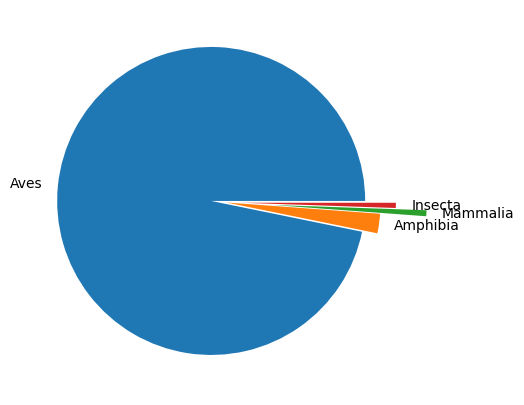

In [11]:
data = np.array(data_w_split_info['class'].value_counts().values)
labels = np.array(data_w_split_info['class'].value_counts().index)
explode = [0.1,0.0,0.3, 0.1]
plt.figure(figsize=(5, 5))
plt.pie(data, labels=labels, explode = explode)
plt.show()

We observe that data is highly imbalanced so we will need to address the unbalanced dataset.

In [12]:
# Distribution of Dataset across each Species
data_w_split_info['primary_label'].value_counts()

primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
          ... 
42113        2
21116        2
1139490      2
21038        2
64862        2
Name: count, Length: 206, dtype: int64

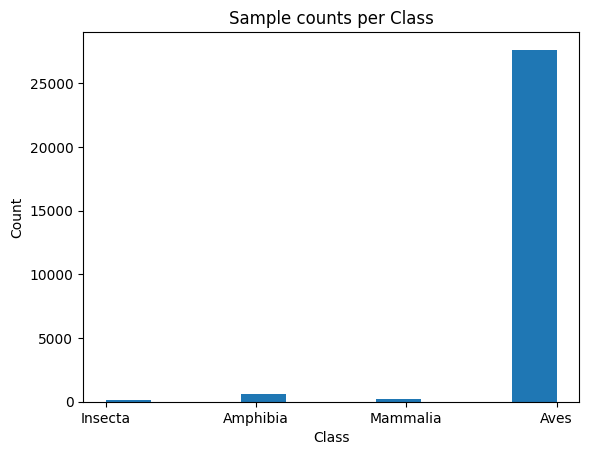

In [13]:
plt.hist(data_w_split_info['class'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title("Sample counts per Class")
plt.show()

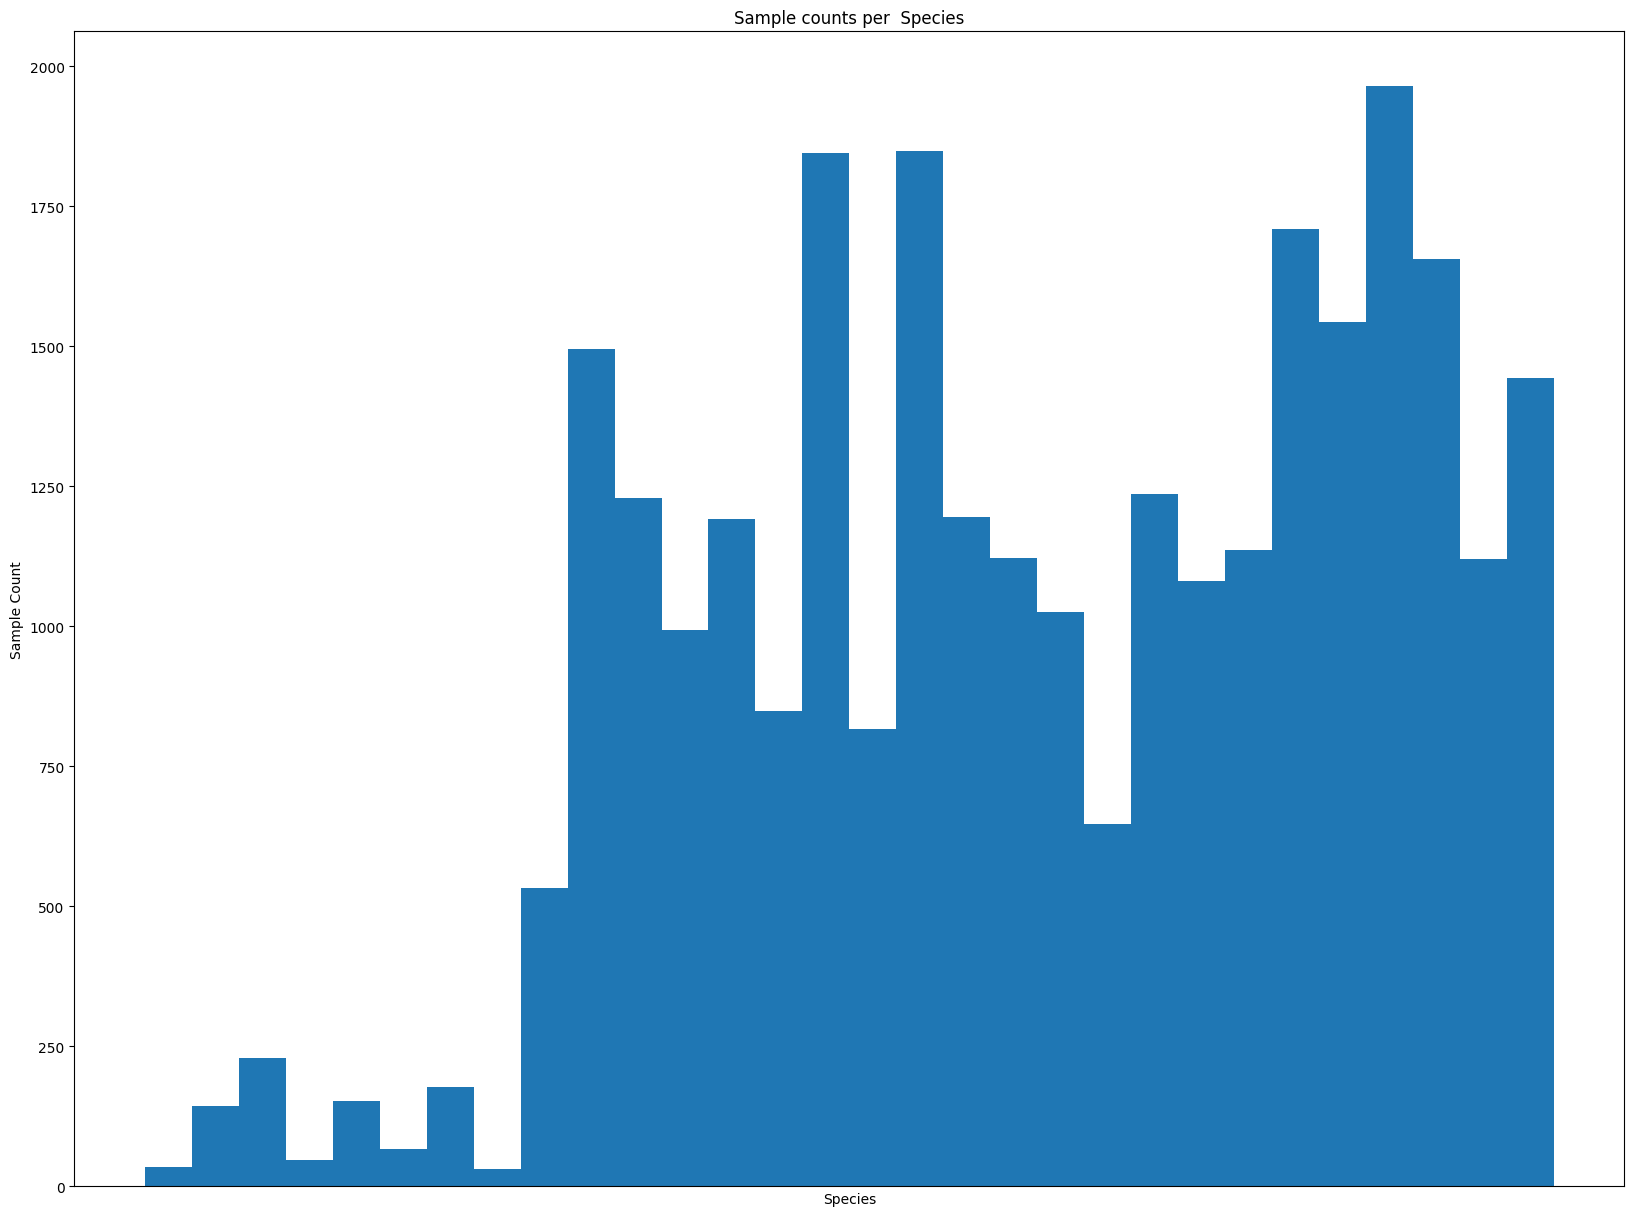

In [14]:

fig = plt.figure(figsize=(20, 15))
plt.hist(data_w_split_info['primary_label'], bins=30)
plt.xlabel('Species')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Sample Count')
plt.title("Sample counts per  Species")
plt.show()

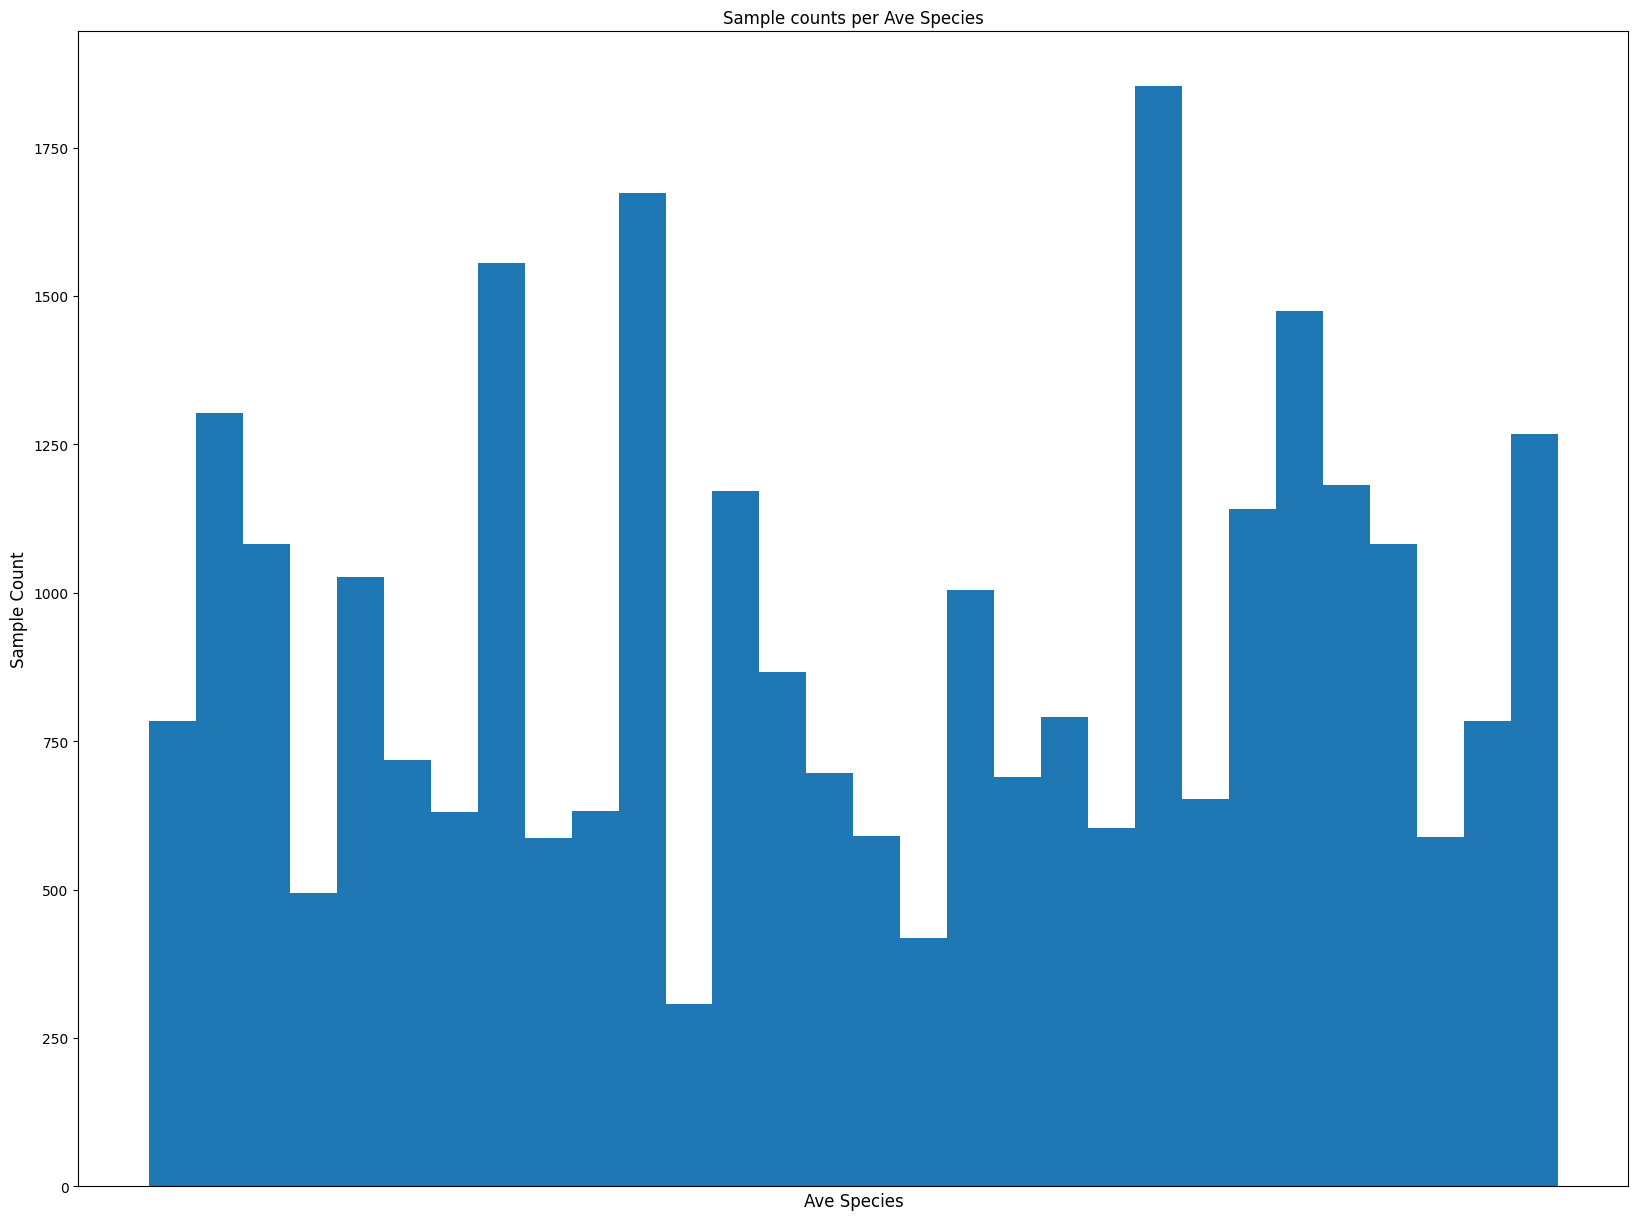

In [15]:
ave_samples = data_w_split_info[data_w_split_info['class']== 'Aves']
fig = plt.figure(figsize=(20, 15))
plt.hist(ave_samples['primary_label'], bins=30)
plt.xlabel('Ave Species', fontsize='large')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Sample Count', fontsize='large')
plt.title("Sample counts per Ave Species")
plt.show()

In [16]:
species_counts = data_w_split_info["primary_label"].value_counts()
print(f"{list(species_counts.index)[0]} Species has highest samples count :  ", max(species_counts) ,
      f"\n{list(species_counts.index)[-1]} Species has lowest samples count : ", min(species_counts))

top_species = list((species_counts[species_counts > 500]).index)
top_species_class = np.unique(list(data_w_split_info[data_w_split_info["primary_label"].isin(top_species)]["class"]))
print("top_species_class", top_species_class)

high_count_species = list((species_counts[species_counts < 500]).index)
low_count_species = list((species_counts[species_counts < 500]).index)


grekis Species has highest samples count :   990 
64862 Species has lowest samples count :  2
top_species_class ['Aves']


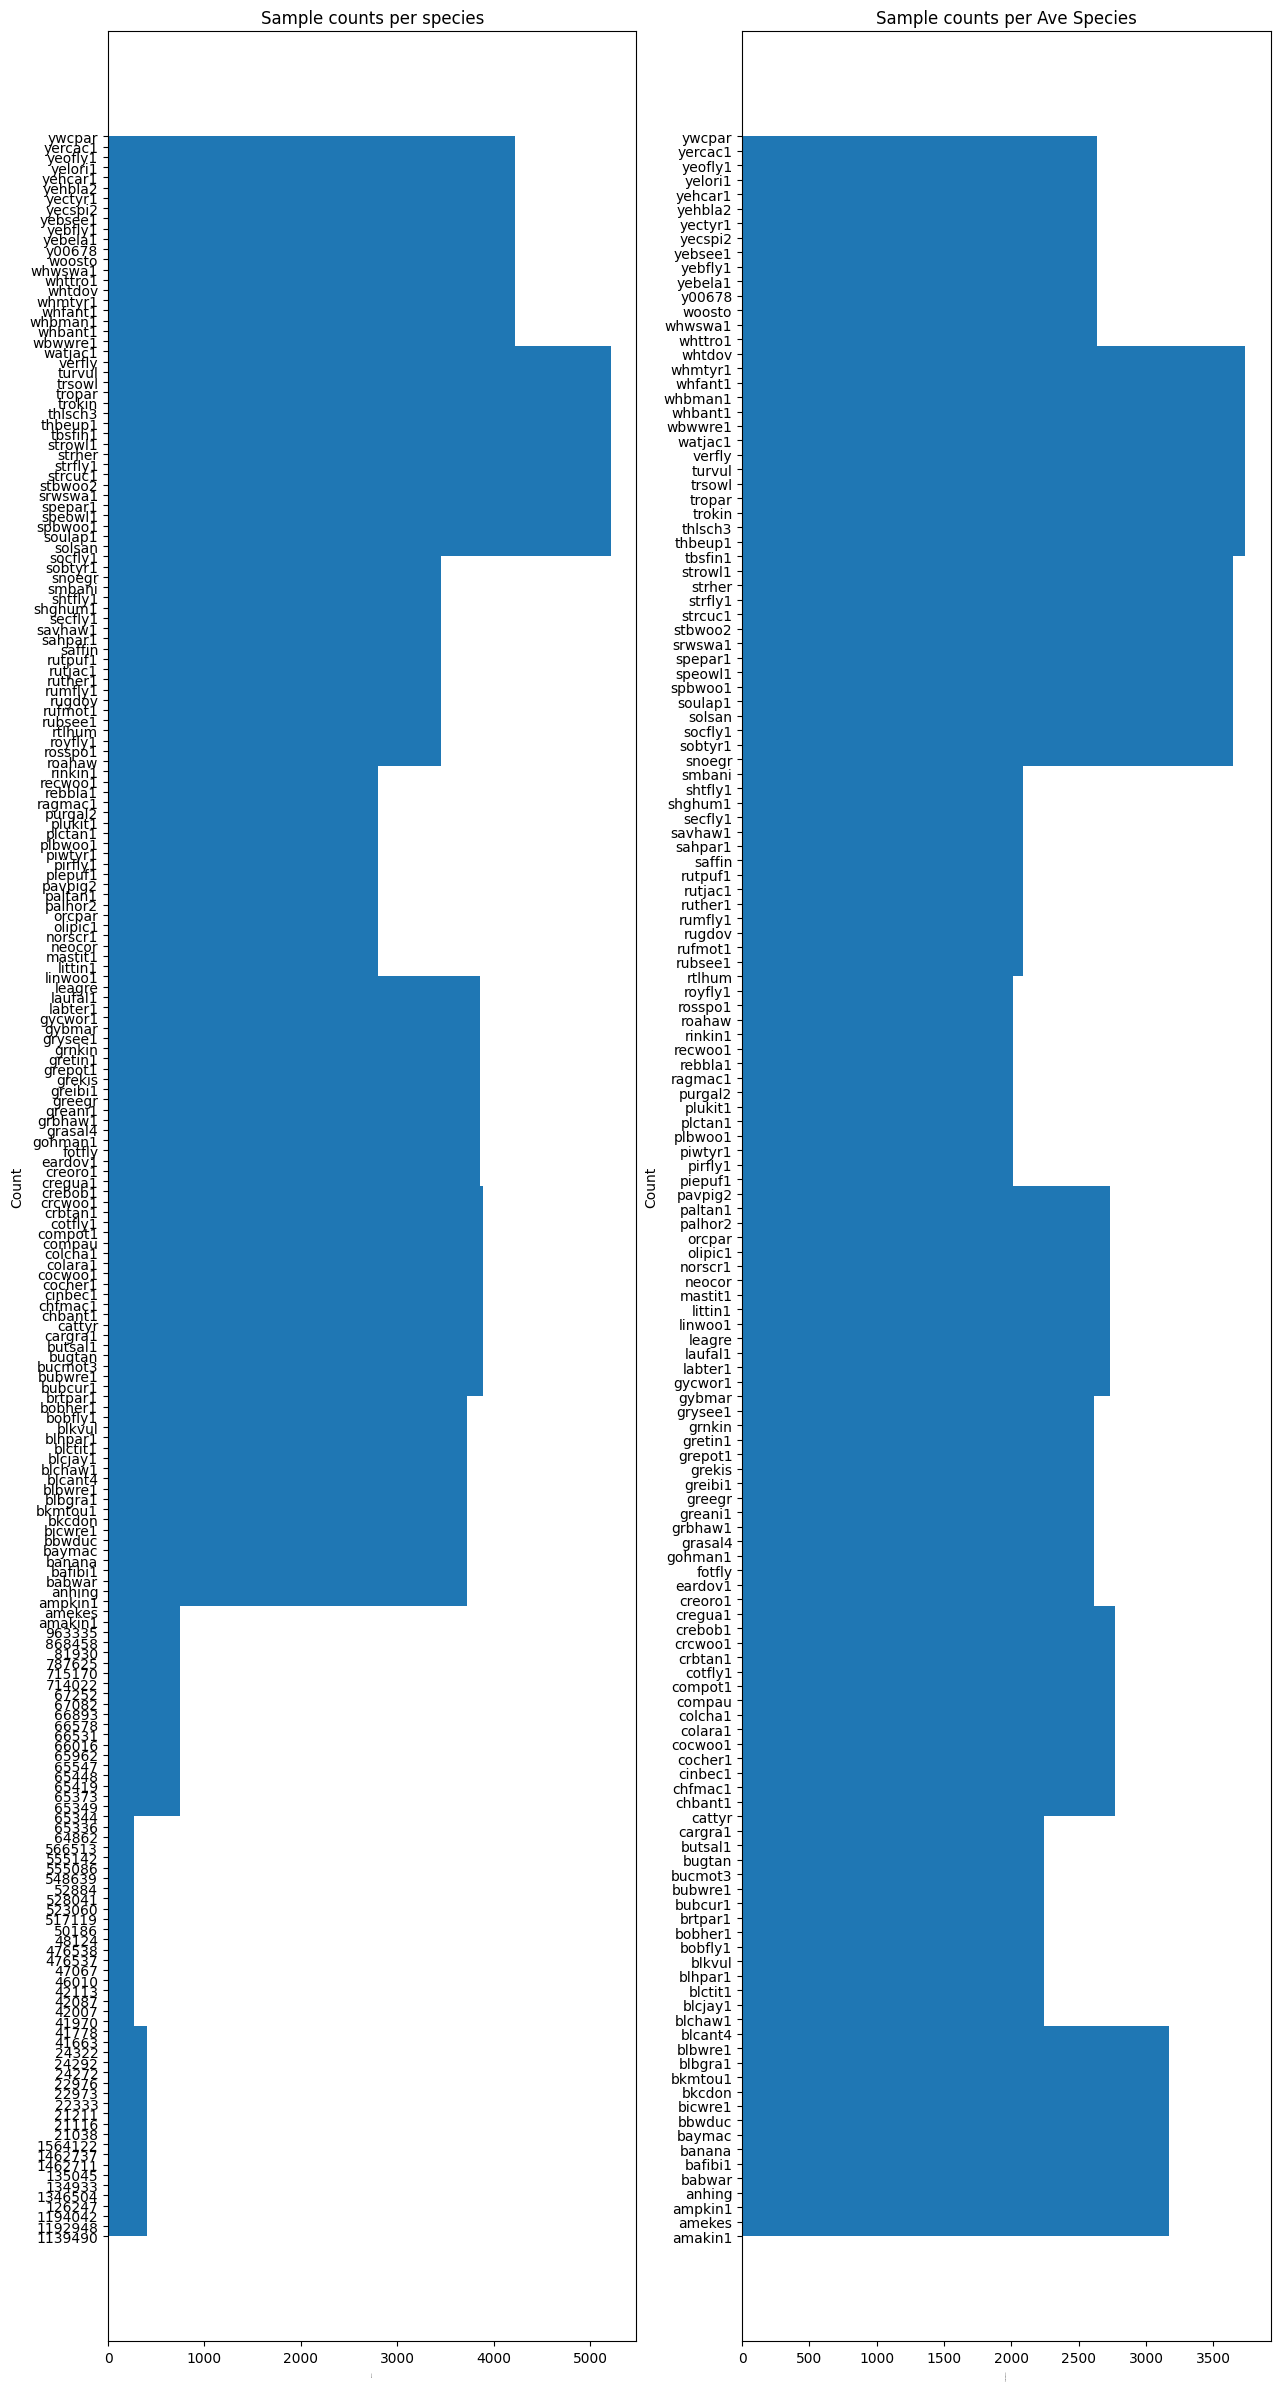

In [17]:
# Horizontal Histogram plot for sample counts per species
fig = plt.figure(figsize=(15,30))

ax = fig.add_subplot(1,2,1)
ax.hist(data_w_split_info['primary_label'], orientation='horizontal')
ax.set_xlabel('Species', fontsize=1, rotation=90)
ax.set_ylabel('Count')
ax.set_title("Sample counts per species")

ave_samples = data_w_split_info[data_w_split_info['class']== 'Aves']
ax=fig.add_subplot(1,2,2)
ax.hist(ave_samples['primary_label'], orientation='horizontal')
ax.set_xlabel('Aves Species', fontsize=1, rotation=90)
ax.set_ylabel('Count')
ax.set_title("Sample counts per Ave Species")


plt.show()


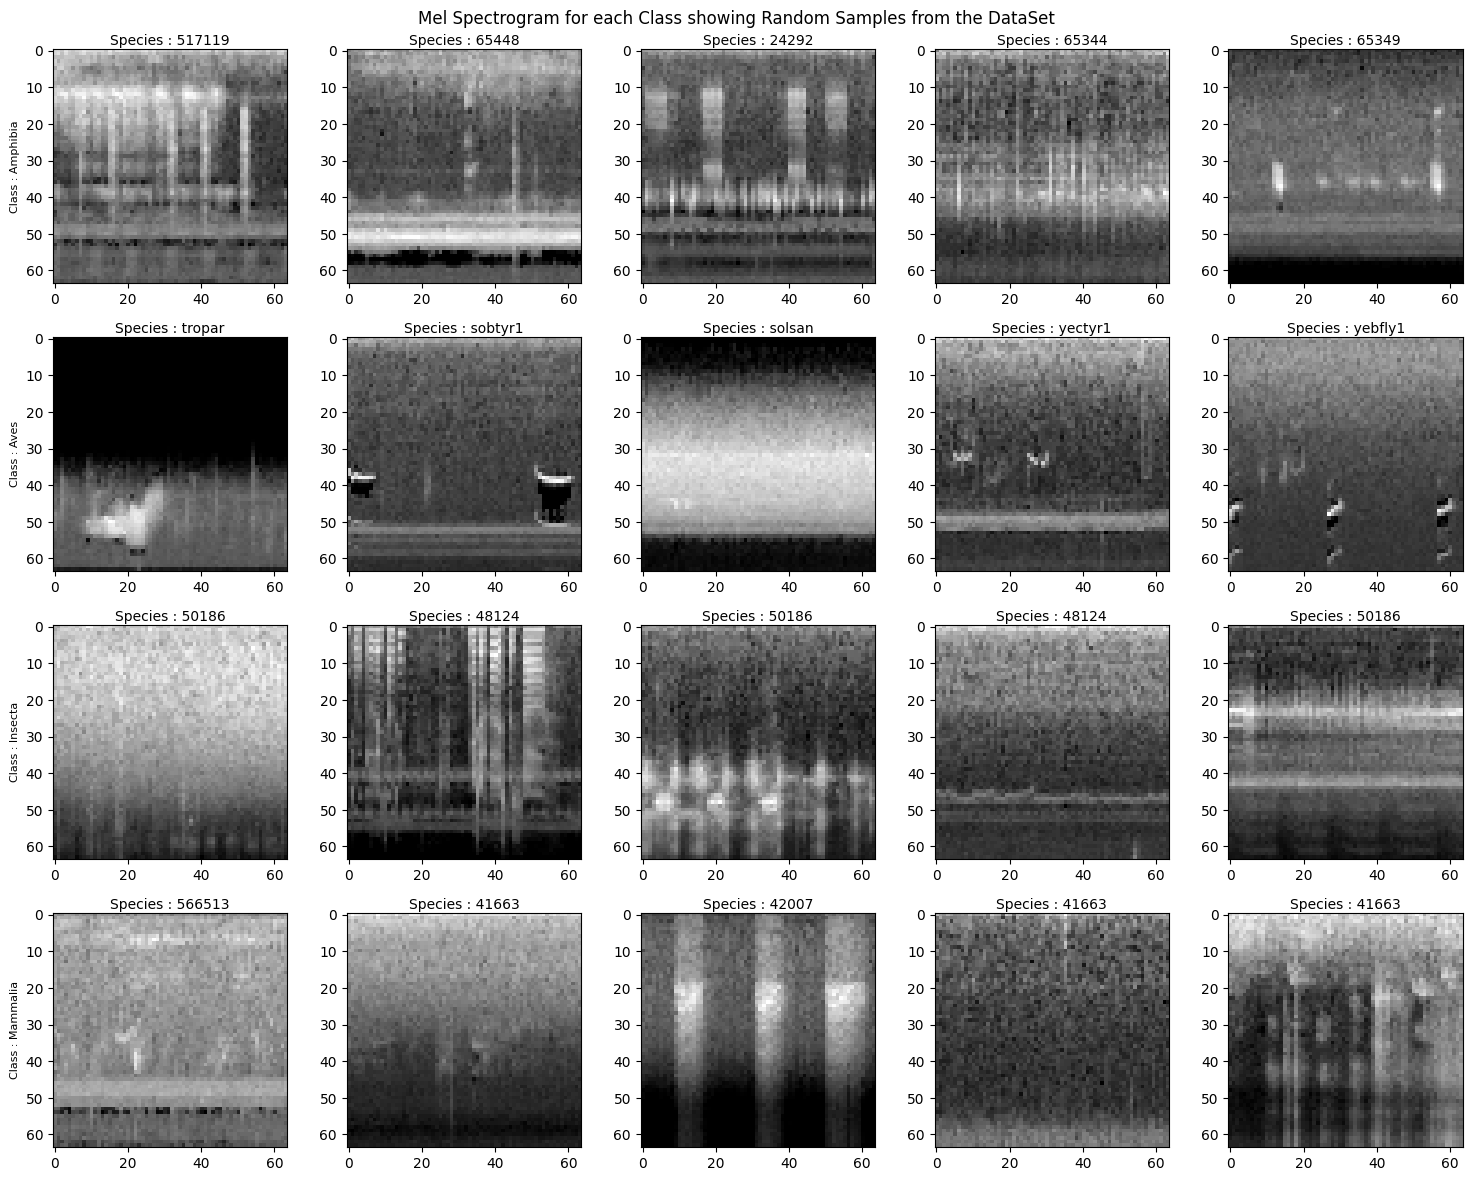

In [18]:
np.random.seed(1234)
class_list = np.unique(data_w_split_info['class'])

rows = len(class_list)
cols = 5
index = 0
fig, axes = plt.subplots(rows,cols, figsize=(cols*3,rows*3))
for row in np.arange(rows):
    df = data_w_split_info[data_w_split_info['class'] == class_list[row]]
    random_samples = random.sample(sorted(np.array(df[df['primary_label'].isin(high_count_species)]['samplename'])), 5)
    for col in np.arange(cols):
        ax = axes[row,col]
        ax.imshow(graph_dict[random_samples[col]], cmap='gray')
        species_name = data_w_split_info[data_w_split_info['samplename'] == random_samples[col]]['primary_label']
        if col == 0:
          class_title = "Class : " + class_list[row]
          ax.set_ylabel(class_title, fontsize=8)
        species_title = "Species : " + list(species_name)[0]
        ax.set_title(species_title, fontsize=10, va='center')
        index += 1
plt.suptitle("Mel Spectrogram for each Class showing Random Samples from the DataSet")
plt.tight_layout()
#plt.subplots_adjust(top=0.9)
plt.show()


Observations: We observe the images for the same class look quite different for different species.  Images across different classes appear to be similar. Difficult task to classifiy these images.

# Baseline Predictions

In [19]:
#Baseline Class Predictions
class_counts = train_species_class_df['class'].value_counts()
#Identify class with most audio samples in training dataset
class_list = list(np.unique(train_species_class_df['class']))
majority_class = list(class_counts.index)[0]
print(f"{majority_class} class  has highest samples count :  ", int(class_counts.values[0]))

## Create a baseline model for species classification
y_baseline = ( train_species_class_df['class'] == majority_class).astype(int)
#print('y_baseline=', y_baseline)
## Building baseline
num_majority_class = np.sum(y_baseline == 1)
print(f"Number of samples with {majority_class} class : {num_majority_class}")

num_non_majority_class = np.sum(y_baseline== 0)
print(f"Number of samples with non-{majority_class} class : {num_non_majority_class}")

majority_label = 1 if num_majority_class > num_non_majority_class else 0
print(f"Majority label: {majority_label}")

majority_predictions = np.full(y_baseline.shape, majority_label)
accuracy = np.mean(majority_predictions == y_baseline)
print(f"Accuracy of majority label classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred):
    loss = -np.mean(y_true * np.log(y_pred) +
                    (1.0 - y_true) * np.log(abs(1.0 - y_pred)))
    return loss

#Have to make baseline prediction be non zero so log function can work
baseline_pred = np.ones(y_baseline.shape[0])*(majority_label + 0.1 )
#print('baseline_pred=', baseline_pred)
train_log_loss = log_loss(y_baseline, baseline_pred)
print(f"Log Loss on training data: {train_log_loss:.4f}")


Aves class  has highest samples count :   16588
Number of samples with Aves class : 16588
Number of samples with non-Aves class : 550
Majority label: 1
Accuracy of majority label classifier: 0.9679
Log Loss on training data: -0.0184


In [20]:
#Baseline Species Prediction

#Identify species with most audio samples in training dataset
species_list = list(np.unique(train_species_class_df['primary_label']))
majority_species = list(species_counts.index)[0]
minority_species = list(species_counts.index)[-1]
class_name_max = list(train_species_class_df[train_species_class_df['primary_label'] == majority_species]["class"])[0]
print(f"{majority_species} Species from class {class_name_max} has highest samples count :  ", int(species_counts.values[0]))

## Create a baseline model for species classification
y_baseline = ( train_species_class_df['primary_label'] == majority_species).astype(int)

## Building baseline
num_majority_species = np.sum(y_baseline == 1)
print(f"Number of samples with {majority_species} species : {num_majority_species}")

num_non_majority_species = np.sum(y_baseline== 0)
print(f"Number of samples with non-{majority_species} species: {num_non_majority_species}")

majority_label = 1 if num_majority_species > num_non_majority_species else 0
print(f"Majority label: {majority_label}")

majority_predictions = np.full(y_baseline.shape, majority_label)
accuracy = np.mean(majority_predictions == y_baseline)
print(f"Accuracy of majority label classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred):
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

#Have to make baseline prediction be non zero so log function can work
baseline_pred = np.ones(y_baseline.shape[0])*(majority_label + 0.1 )

train_log_loss = log_loss(y_baseline, baseline_pred)
print(f"Log Loss on training data: {train_log_loss:.4f}")


grekis Species from class Aves has highest samples count :   990
Number of samples with grekis species : 597
Number of samples with non-grekis species: 16541
Majority label: 0
Accuracy of majority label classifier: 0.9652
Log Loss on training data: 0.1819


We observe that baseline model has very high accuracy due to unbalanced data.

# Preparing data for ML

In [21]:
## Prep data for ML

def one_hot_encode_y(encoded_y, num_classes):
  #One hot encode the y labels
  return to_categorical(encoded_y, num_classes)

X_common_train, X_common_val, X_common_test  = [], [], []
y_species_train, y_species_val, y_species_test  = [], [], []
y_class_train, y_class_val, y_class_test  = [], [], []

# One hot encode y labels
y_species_categorical = to_categorical(data_w_split_info['y_species_encoded'],
                               num_classes = len(np.unique(data_w_split_info['y_species_encoded'])))
y_class_categorical = to_categorical(data_w_split_info['y_class_encoded'],
                               num_classes = len(np.unique(data_w_split_info['y_class_encoded'])))
counter = 0
while counter <  data_w_split_info.shape[0]:
      sample = data_w_split_info.iloc[counter]
      img = graph_dict.get(sample['samplename'])
      #Add 1 color channel to grayscale image so we can use with CNN
      img = img.reshape(img.shape + (1,))
      if sample['split'] == 'train':
        X_common_train.append(img)
        y_species_train.append(sample['y_species_encoded'])
        y_class_train.append(sample['y_class_encoded'])
      elif sample['split'] == 'val':
        X_common_val.append(img)
        y_species_val.append(sample['y_species_encoded'])
        y_class_val.append(sample['y_class_encoded'])
      else :
        X_common_test.append(img)
        y_species_test.append(sample['y_species_encoded'])
        y_class_test.append(sample['y_class_encoded'])
      counter += 1
X_common_train = np.array(X_common_train)
X_common_val = np.array(X_common_val)
X_common_test = np.array(X_common_test)

#One hot encode the y labels
num_species = 206
num_classes = len(np.unique(y_class_train))
print("num_species = ", num_species , "\nnum_classes = ", num_classes)

y_species_train = one_hot_encode_y(np.array(y_species_train),num_species )
y_species_val = one_hot_encode_y(np.array(y_species_val),num_species )
y_species_test = one_hot_encode_y(np.array(y_species_test),num_species )

y_class_train = one_hot_encode_y(np.array(y_class_train),num_classes )
y_class_val = one_hot_encode_y(np.array(y_class_val),num_classes )
y_class_test = one_hot_encode_y(np.array(y_class_test),num_classes )


#Set Random Seed
tf.random.set_seed(1234)
np.random.seed(1234)

# shuffle data
rng = np.random.default_rng(seed=1234)
shuffled_indices_train = rng.permutation(range(X_common_train.shape[0]))
shuffled_indices_val = rng.permutation(range(X_common_val.shape[0]))
shuffled_indices_test = rng.permutation(range(X_common_test.shape[0]))

# shuffle data #
##################
X_common_train = X_common_train[shuffled_indices_train]
y_species_train = y_species_train[shuffled_indices_train]
y_class_train = y_class_train[shuffled_indices_train]

X_common_val = X_common_val[shuffled_indices_val]
y_species_val = y_species_val[shuffled_indices_val]
y_class_val = y_class_val[shuffled_indices_val]

X_common_test = X_common_test[shuffled_indices_test]
y_species_test = y_species_test[shuffled_indices_test]
y_class_test = y_class_test[shuffled_indices_test]



print(f'X_common_train shape: {X_common_train.shape}')
print(f'y_species_train shape: {y_species_train.shape}')
print(f'y_class_train shape: {y_class_train.shape}')

print(f'X_common_val shape: {X_common_val.shape}')
print(f'y_species_val shape: {y_species_val.shape}')
print(f'y_class_val shape: {y_class_val.shape}')

print(f'X_common_test shape: {X_common_test.shape}')
print(f'y_species_test shape: {y_species_test.shape}')
print(f'y_class_test shape: {y_class_test.shape}')

num_species =  206 
num_classes =  4
X_common_train shape: (17138, 64, 64, 1)
y_species_train shape: (17138, 206)
y_class_train shape: (17138, 4)
X_common_val shape: (5713, 64, 64, 1)
y_species_val shape: (5713, 206)
y_class_val shape: (5713, 4)
X_common_test shape: (5713, 64, 64, 1)
y_species_test shape: (5713, 206)
y_class_test shape: (5713, 4)


# Modeling

## Common methods

In [22]:
#Calculate class weights due to class imbalance
unique_classes = np.unique(train_species_class_df['y_class_encoded'])
class_weights_list = compute_class_weight(
                                        class_weight='balanced',
                                        classes=unique_classes,
                                        y=train_species_class_df['y_class_encoded'])
# Convert to a dictionary for Keras/TensorFlow
class_weights_dict = dict(zip(unique_classes,
                              class_weights_list))




#Species class weights
unique_species = np.unique(train_species_class_df['y_species_encoded'])
species_class_weights_list = compute_class_weight(
                                        class_weight='balanced',
                                        classes=unique_species,
                                        y=train_species_class_df['y_species_encoded'])
# Convert to a dictionary for Keras/TensorFlow
species_class_weights_dict = dict(zip(unique_species,
                              species_class_weights_list))





In [23]:
# Plot the loss at each epoch and show final numbers.
def show_history(history):
  """

  """
  # plot loss curves
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 3, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=10)
  ax.set_title("Model Loss ")

  ax = fig.add_subplot(1, 3, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=10)
  ax.set_title("Model Accuracy")
  ax.set_ylim(0,1)

  ax = fig.add_subplot(1, 3, 3)
  ax.plot(x_arr, hist['f1_score'], '-o', label='Train F1 score.')
  ax.plot(x_arr, hist['val_f1_score'], '--<', label='Val F1 Score.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('F1 score', size=10)
  ax.set_title("Model F1 Score ")
  ax.set_ylim(0,1)
  plt.show()

  # evaluate the accuracy of model_tf on train and val datasets
  train_acc = hist['accuracy'][-1]
  val_acc = hist['val_accuracy'][-1]
  print('final train acc: %.3f' %train_acc)
  print('final val acc:   %.3f' %val_acc)
  if int(train_acc ) == 0:
    print("\nUnable to calculate percent diff as Train accuracy is zero")
  else:
    percent_diff = 100*(train_acc - val_acc)/train_acc
    print('\nPercent Diff in Acc. {:.2f}%'.format(percent_diff))


In [24]:
def plot_confusion_matrix(trained_model, train_data, label_data, **kwargs):
  """
  """
  class_labels = []
  keys = kwargs.keys()
  for key in keys:
    if key == 'class_labels': class_labels=kwargs['class_labels']

  if  len(class_labels)==0:
    class_labels = ['Amphibia' , 'Aves', 'Insecta', 'Mammalia']

  y_hat = trained_model.predict(train_data, verbose=0)

  y_actual = [int(np.argmax(label)) for label in label_data]
  predicted_labels = [int(np.argmax(label)) for label in y_hat]
  print("test_label length : ", len(y_actual))
  print("predicted_labels length : ", len(predicted_labels))
  conf_matrix =  confusion_matrix(y_actual, predicted_labels)
  print("confusion matrix shape=", conf_matrix.shape)

  # Plot normalized confusion matrix
  disp = ConfusionMatrixDisplay.from_predictions(
          y_actual,
          predicted_labels,
          display_labels=class_labels,
          cmap=plt.cm.Blues,
          normalize='true',
      )
  disp.ax_.set_title("Normalized confusion matrix")
  plt.show()

  #print classification report
  print(classification_report(y_actual, predicted_labels, target_names=class_labels))

In [25]:
# define an instance of the early_stopping class
early_stopping_acc = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [26]:
# define an instance of the early_stopping class
early_stopping_f1 = tf.keras.callbacks.EarlyStopping(
monitor='val_f1_score',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [27]:
# define an instance of the ReduceLROnPlateau class
reduce_lr_acc = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

In [28]:
# define an instance of the ReduceLROnPlateau class
reduce_lr_f1 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

### Data Augmentation functions

To address the highly unbalanced class labels, we will attempt augmentation using Resampling and Undersampling to balance the classes.

In [29]:
def add_smote_augmentation(train_data, train_label):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #SMOTE expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        X_resampled, y_resampled = SMOTE().fit_resample(train_data, train_label)

        print("After augmentation: X shape:", X_resampled.shape)
        print("After augmentation: y shape:", y_resampled.shape)

        #Rebuild our 4D data array
        X_resampled = X_resampled.reshape(X_resampled.shape[0], original_shape[1], original_shape[2], original_shape[3])
        print("Reshaped X_resampled : ",X_resampled.shape )

        return X_resampled, y_resampled

In [30]:
def add_adasyn_augmentation(train_data, train_label):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #ADASYN expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        X_resampled, y_resampled = ADASYN().fit_resample(train_data, train_label)
        #print(sorted(Counter(y_resampled).items()))


        print("After augmentation: X shape:", X_resampled.shape)
        print("After augmentation: y shape:", y_resampled.shape)

        #Rebuild our 4D data array
        X_resampled = X_resampled.reshape(X_resampled.shape[0], original_shape[1], original_shape[2], original_shape[3])
        print("Reshaped X_resampled : ",X_resampled.shape )

        return X_resampled, y_resampled

In [31]:
def create_undersampled_data(train_data, train_label, undersampl_type=1):
        print("Before augmentation: X shape:", train_data.shape)
        print("Before augmentation: y shape:", train_label.shape)

        #undersample expects 1D or 2D array at most. So need to reshape our 4D array
        original_shape = train_data.shape
        train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
        print("Reshaped train data : ",train_data.shape )

        # define the undersampling method
        #undersample = CondensedNearestNeighbour(n_neighbors=1)
        if undersampl_type == 1:
            undersample = NearMiss( sampling_strategy="majority", version=3, n_neighbors_ver3=3)
        elif undersampl_type == 2:
            undersample = CondensedNearestNeighbour(sampling_strategy="majority",  n_neighbors=3)

        # transform the dataset
        X_undersampled, y_undersampled = undersample.fit_resample(train_data, train_label)
        #print(sorted(Counter(y_resampled).items()))

        print("After augmentation: X shape:", X_undersampled.shape)
        print("After augmentation: y shape:", y_undersampled.shape)

        #Rebuild our 4D data array
        X_undersampled = X_undersampled.reshape(X_undersampled.shape[0],
                                                original_shape[1],
                                                original_shape[2],
                                                original_shape[3])
        print("Reshaped X_undersampled : ",X_undersampled.shape )

        return X_undersampled, y_undersampled

#### Spectrogram Augmentation

In [32]:
def time_masking_batch(spectrograms, max_mask_size=30):
    def mask_one(spec):
        time_steps = tf.shape(spec)[0]
        mask_size = tf.random.uniform([], 0, max_mask_size + 1, dtype=tf.int32)
        start = tf.random.uniform([], 0, time_steps - mask_size + 1, dtype=tf.int32)

        mask = tf.concat([
            tf.ones((start, spec.shape[1]), dtype=tf.float32),
            tf.zeros((mask_size, spec.shape[1]), dtype=tf.float32),
            tf.ones((time_steps - start - mask_size, spec.shape[1]), dtype=tf.float32)
        ], axis=0)
        return spec * mask

    return tf.map_fn(mask_one, spectrograms)
def frequency_masking_batch(spectrograms, max_mask_size=20):
    def mask_one(spec):
        freq_bins = tf.shape(spec)[1]
        mask_size = tf.random.uniform([], 0, max_mask_size + 1, dtype=tf.int32)
        start = tf.random.uniform([], 0, freq_bins - mask_size + 1, dtype=tf.int32)

        mask = tf.concat([
            tf.ones((spec.shape[0], start), dtype=tf.float32),
            tf.zeros((spec.shape[0], mask_size), dtype=tf.float32),
            tf.ones((spec.shape[0], freq_bins - start - mask_size), dtype=tf.float32)
        ], axis=1)
        return spec * mask

    return tf.map_fn(mask_one, spectrograms)
def time_shift_batch(spectrograms, max_shift=20):
    def shift_one(spec):
        shift = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
        return tf.roll(spec, shift=shift, axis=0)

    return tf.map_fn(shift_one, spectrograms)
def amplitude_scaling_batch(spectrograms, scale_range=(0.7, 1.3)):
    def scale_one(spec):
        scale = tf.random.uniform([], scale_range[0], scale_range[1])
        return spec * scale

    return tf.map_fn(scale_one, spectrograms)

def apply_batched_augmentations(spectrograms):
  spectrograms = time_masking_batch(spectrograms)
  if np.random.rand() < 0.5:
    spectrograms = frequency_masking_batch(spectrograms)
  if np.random.rand() < 0.5:
    spectrograms = time_shift_batch(spectrograms)
  if np.random.rand() < 0.5:
    spectrograms = amplitude_scaling_batch(spectrograms)

  return spectrograms

In [33]:
def add_spectrogram_augmentation(spectrograms_4d, label_data):
  """Apply spectrogram augmentation to the images
  """
  #1 Reshape data to remove color channel
  spectrograms_2d =  spectrograms_4d.reshape(spectrograms_4d.shape[0],
                                             spectrograms_4d.shape[1],
                                             spectrograms_4d.shape[2])
  print("Reshaped spectrogram shape : ", spectrograms_2d.shape)

  #2 Convert spectrogram to tensor
  spect_tensor = tf.convert_to_tensor(spectrograms_2d)
  spect_augm = ( apply_batched_augmentations(spect_tensor))
  print("Augmented spectrograms shape: ", spect_augm.shape)

  #3 Convert tensor back to numpy array and reshape with color channel
  spect_augm = spect_augm.numpy()
  spect_augm = spect_augm.reshape(spect_augm.shape + (1,) )
  print("Reshaped Augmented spectrograms shape: ", spect_augm.shape)

  #4 # concatenate original X and augmented X_aug data
  X_spec_augm = tf.concat([spectrograms_4d, spect_augm], axis=0)

  # concatenate y_train (note the label is preserved)
  y_augm = label_data
  y_spec_augm = tf.concat([label_data, y_augm],axis=0)
  print("After augmentation: X shape:", X_spec_augm.shape)
  print("After augmentation: y shape:", y_spec_augm.shape)

  return X_spec_augm, y_spec_augm

## Building Models

In [34]:

def build_functional_model_1(img_size, output_size):
  """ Model_1 has one convolutional layer followed by a MaxPool
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  conv_1 = tf.keras.layers.Conv2D(filters=64,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)

  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(conv_1)
  flat_1 = tf.keras.layers.Flatten()(maxpool_1)

  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

In [35]:
def build_functional_model_2(img_size, output_size):
  """ Model_2 has 2 blocks of convolutional layer followed by BatchNormalization and MaxPool
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=32,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 64,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(normal_2)

  flat_1 = tf.keras.layers.Flatten()(maxpool_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

In [36]:
def build_functional_model_3(img_size, output_size):
  """ Model_3 has 3 blocks of convolutional layer followed by DenseLayer
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  #Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=32,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 64,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(normal_2)

 # Block 3
  conv_3 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(maxpool_2)
  normal_3 = tf.keras.layers.BatchNormalization()(conv_3)
  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(normal_3)


  # Add a flattening layer
  flat_1 = tf.keras.layers.GlobalAveragePooling2D()(maxpool_3)
  dense_1 = tf.keras.layers.Dense(32, activation='relu')(flat_1)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dense_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

In [37]:
def build_functional_model_4(img_size, output_size):
  """ Model_4 has 2 blocks of convolutional layer followed by a DenseLayer
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  #Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=32,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 64,
      kernel_size=(4,4),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(normal_2)


  # Add a flattening plus Dense layer
  flat_1 = tf.keras.layers.Flatten()(maxpool_2)
  dense_1 = tf.keras.layers.Dense(32, activation='relu')(flat_1)
  dropout_1 = tf.keras.layers.Dropout(0.1)(dense_1)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])

  # print model_tf summary
  print(model.summary())
  return model

In [38]:
def build_functional_model_5(img_size, output_size):
  """ Model_5 has 5 blocks of convolutional layer followed by 3 Dense layers
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)

  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')

  #Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=32,
      kernel_size=(3,3),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 64,
      kernel_size=(3,3),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(normal_2)


 # Block 3
  conv_3 = tf.keras.layers.Conv2D(filters= 128,
      kernel_size=(3,3),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_3',
      activation='relu')(maxpool_2)
  normal_3 = tf.keras.layers.BatchNormalization()(conv_3)
  maxpool_3 = tf.keras.layers.MaxPooling2D((2,2))(normal_3)

  # Block 4
  conv_4 = tf.keras.layers.Conv2D(filters= 256,
      kernel_size=(3,3),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_4',
      activation='relu')(maxpool_3)
  normal_4 = tf.keras.layers.BatchNormalization()(conv_4)
  maxpool_4 = tf.keras.layers.MaxPooling2D((2,2))(normal_4)

  # Add 5th convolutional layer
  conv_5 = tf.keras.layers.Conv2D(filters= 512,
      kernel_size=(3,3),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_5',
      activation='relu')(maxpool_4)
  normal_5 = tf.keras.layers.BatchNormalization()(conv_5)
  maxpool_5 = tf.keras.layers.MaxPooling2D((2,2))(normal_5)




  # Add a GlobalAverage plus flattening layer
  flat_1 = model.add(layers.GlobalAveragePooling2D())(maxpool_5)
  dense_1 = tf.keras.layers.Dense(256, activation='relu')(flat_1)
  dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)
  dense_3 = tf.keras.layers.Dense(64, activation='relu')(dense_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dense_3)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model

## Model Execution

### Model 1

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │       262,148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,236 (1.00 MB)

 Trainable params: 263,236 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1717 - f1_score: 0.0830 - loss: 156.9117 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3904 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3323 - f1_score: 0.1332 - loss: 1.3352 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3747 - learning_rate: 0.1000
Epoch 3/20
529/536 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3391 - f1_score: 0.1350 - loss: 1.3348
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3377 - f1_score: 0.1347 - loss: 1.3360 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3702 - learning_rate: 0.1000
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3544 - f1_score: 0.1380 - loss: 1.3239 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.4727 - learning_rate: 0.0500
Epoch 5/20
532/536 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

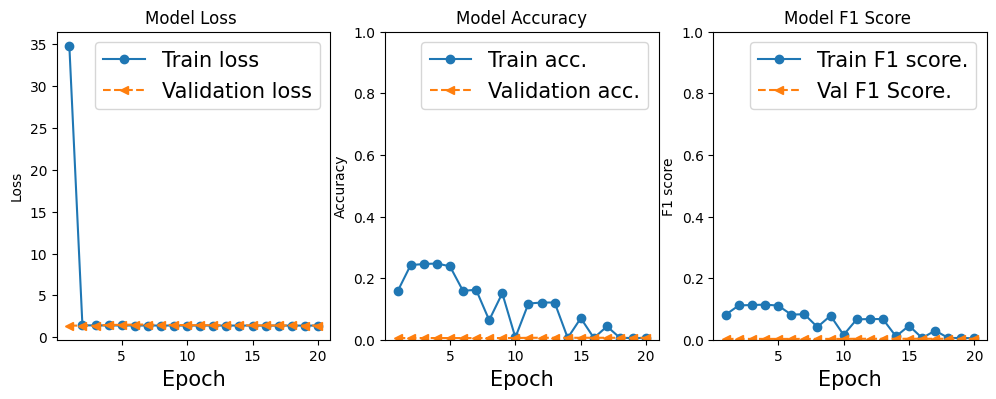

final train acc: 0.005
final val acc:   0.006

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


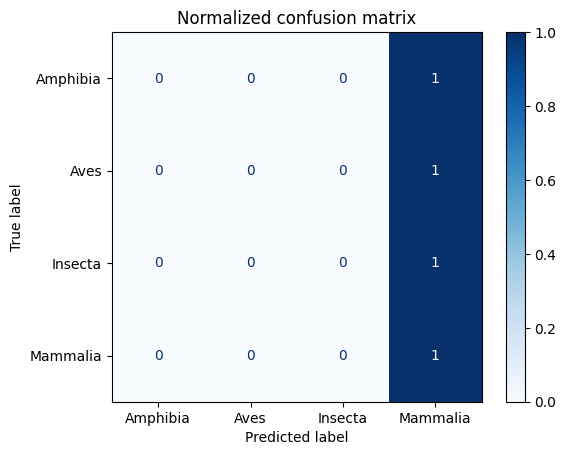

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       350
        Aves       0.00      0.00      0.00     16588
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.01      1.00      0.01       107

    accuracy                           0.01     17138
   macro avg       0.00      0.25      0.00     17138
weighted avg       0.00      0.01      0.00     17138



In [39]:

class_model_1_func = build_functional_model_1(X_common_train.shape[1],y_class_train.shape[1])
# train model on (X_train, y_train) data
history = class_model_1_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[reduce_lr_f1],
    class_weight=class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_1_func, X_common_train, y_class_train)

### Model 2

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2854 - f1_score: 0.1249 - loss: 335.1138 - val_accuracy: 0.0203 - val_f1_score: 0.0100 - val_loss: 915.2495 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2665 - f1_score: 0.1205 - loss: 339.0049 - val_accuracy: 0.2127 - val_f1_score: 0.1065 - val_loss: 506.3060 - learning_rate: 0.1000
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3345 - f1_score: 0.1417 - loss: 383.1447 - val_accuracy: 0.2865 - val_f1_score: 0.1363 - val_loss: 162.8615 - learning_rate: 0.1000
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3285 - f1_score: 0.1440 - loss: 304.4265 - val_accuracy: 0.2344 - val_f1_score: 0.1239 - val_loss: 55.0020 - learning_rate: 0.1000
Epoch 5/20
529/536 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3250 - f1_score: 0.1446 - loss: 197.1105
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━

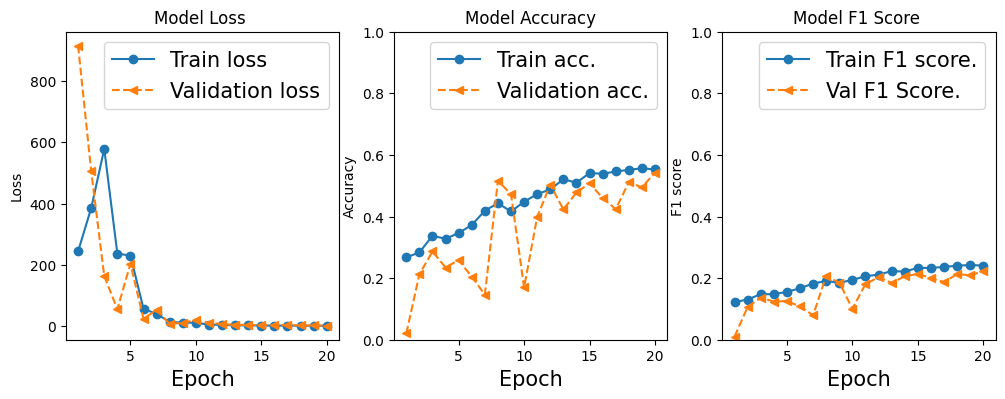

final train acc: 0.553
final val acc:   0.542

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


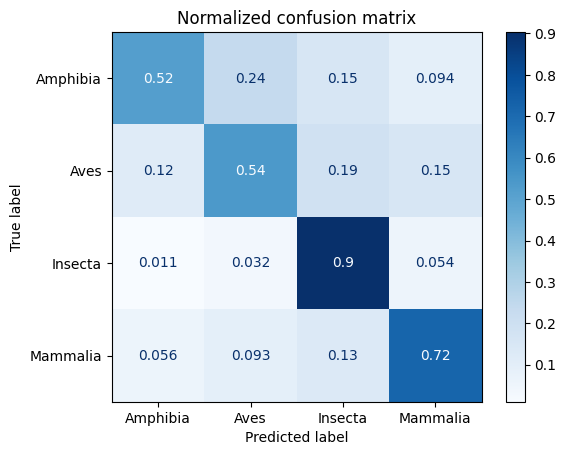

              precision    recall  f1-score   support

    Amphibia       0.08      0.52      0.15       350
        Aves       0.99      0.54      0.70     16588
     Insecta       0.03      0.90      0.05        93
    Mammalia       0.03      0.72      0.06       107

    accuracy                           0.54     17138
   macro avg       0.28      0.67      0.24     17138
weighted avg       0.96      0.54      0.68     17138



In [40]:
class_model_2_func = build_functional_model_2(X_common_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[reduce_lr_f1],
    class_weight=class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_2_func, X_common_train, y_class_train)


### Model 3

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,732 (663.02 KB)

 Trainable params: 169,284 (661.27 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.2640 - f1_score: 0.1180 - loss: 3.5533 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3695 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3402 - f1_score: 0.1352 - loss: 1.3364 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3674 - learning_rate: 0.1000
Epoch 3/20
535/536 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3392 - f1_score: 0.1350 - loss: 1.3363
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3388 - f1_score: 0.1349 - loss: 1.3366 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.3668 - learning_rate: 0.1000
Epoch 4/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3744 - f1_score: 0.1432 - loss: 1.3240 - val_accuracy: 0.0054 - val_f1_score: 0.0027 - val_loss: 1.4692 - learning_rate: 0.0500
Epoch 5/20
535/536 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

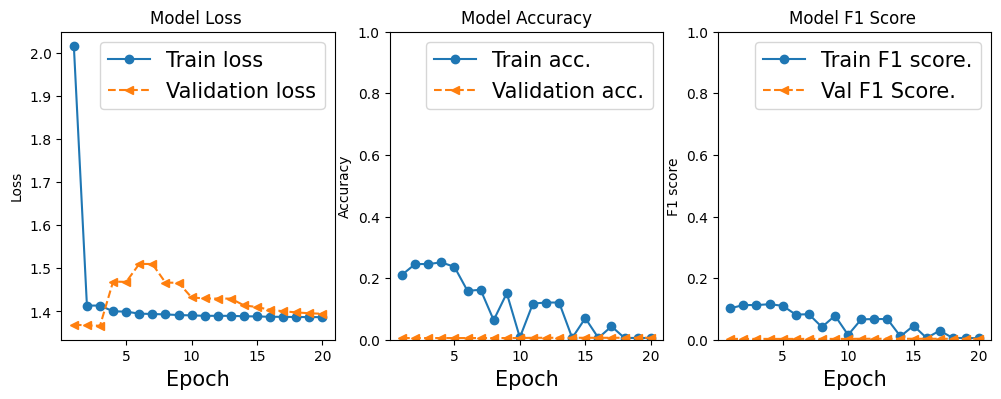

final train acc: 0.005
final val acc:   0.006

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


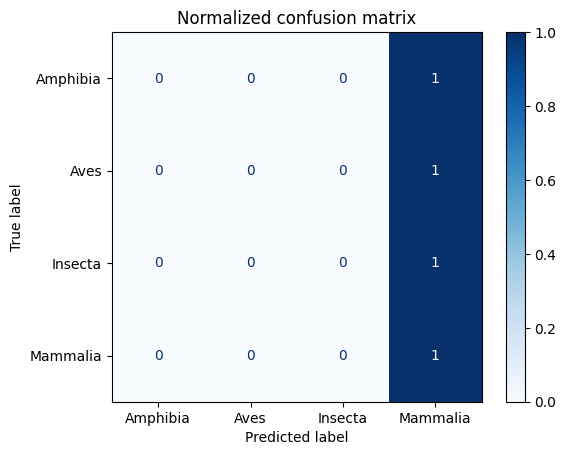

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       350
        Aves       0.00      0.00      0.00     16588
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.01      1.00      0.01       107

    accuracy                           0.01     17138
   macro avg       0.00      0.25      0.00     17138
weighted avg       0.00      0.01      0.00     17138



In [41]:
class_model_3_func = build_functional_model_3(X_common_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_3_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[reduce_lr_f1],
    class_weight=class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_3_func, X_common_train, y_class_train)

### Model 4

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,212 (2.13 MB)

 Trainable params: 558,020 (2.13 MB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1900 - f1_score: 0.1197 - loss: 282.3769 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0027 - val_loss: 1.3652 - learning_rate: 0.1000
Epoch 2/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.1353 - loss: 1.3354 - val_accuracy: 3.5008e-04 - val_f1_score: 0.0029 - val_loss: 2.5057 - learning_rate: 0.1000
Epoch 3/20
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.1357 - loss: 1.3361 - val_accuracy: 5.2512e-04 - val_f1_score: 0.0030 - val_loss: 2.8870 - learning_rate: 0.1000
Epoch 4/20
529/536 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.1352 - loss: 1.3352
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0000e+00 - f1_score: 0.1349 - loss: 1.3364 - val_accuracy: 5.2512e-04 - val_f1_score: 0.0030 - val_loss: 2.9070 - learning_rate: 0.1000
Epoch 5/20
536/

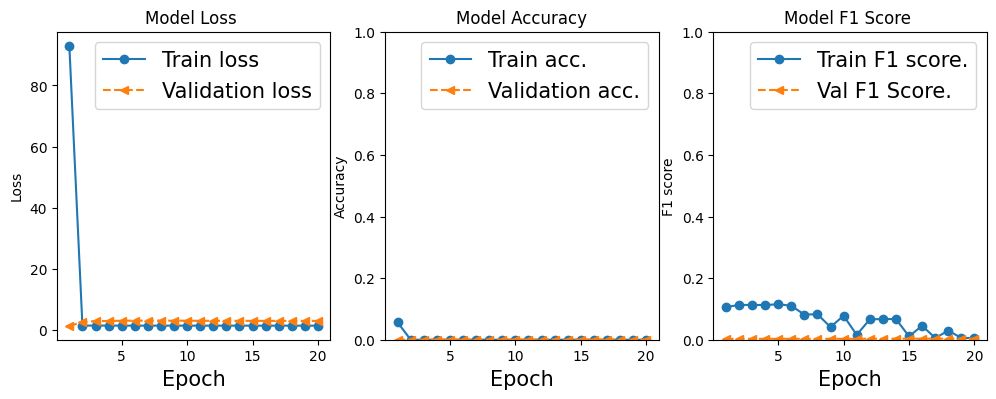

final train acc: 0.000
final val acc:   0.001

Unable to calculate percent diff as Train accuracy is zero
test_label length :  17138
predicted_labels length :  17138
confusion matrix shape= (4, 4)


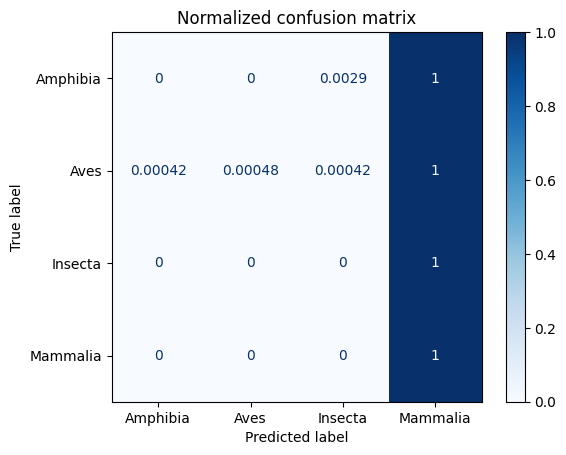

              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       350
        Aves       1.00      0.00      0.00     16588
     Insecta       0.00      0.00      0.00        93
    Mammalia       0.01      1.00      0.01       107

    accuracy                           0.01     17138
   macro avg       0.25      0.25      0.00     17138
weighted avg       0.97      0.01      0.00     17138



In [42]:
class_model_4_func = build_functional_model_4(X_common_train.shape[1],y_class_train.shape[1])

# train model on (X_train, y_train) data
history = class_model_4_func.fit(
    X_common_train,
    y_class_train,
    validation_data=(X_common_val,y_class_val),
    callbacks=[reduce_lr_f1],
    class_weight=class_weights_dict,
    batch_size=32,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(class_model_4_func, X_common_train, y_class_train)

### Summary of Models run so far

Model 2 appears to be most promising so far, so it will be used for further analysis going forward.


|Class weights|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro Precision|Macro Recall|Macro F1|Accuracy|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Yes|1|1|64|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|
|Yes|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|
|Yes|3|4|(16,32,64,128)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|
|Yes|4|6|(8,16,32,64,128,256)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.00|0.25|0.00|0.01|


### Augmentation using Resampling and UnderSampling

#### Resampling using SMOTE

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (66352, 4096)
After augmentation: y shape: (66352, 4)
Reshaped X_resampled :  (66352, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/30
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5686 - f1_score: 0.5677 - loss: 13.1045 - val_accuracy: 0.9680 - val_f1_score: 0.2459 - val_loss: 11.8985 - learning_rate: 0.1000
Epoch 2/30
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8639 - f1_score: 0.8641 - loss: 2.6635 - val_accuracy: 0.9398 - val_f1_score: 0.3280 - val_loss: 20.3932 - learning_rate: 0.1000
Epoch 3/30
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8971 - f1_score: 0.8974 - loss: 12.5097 - val_accuracy: 0.7698 - val_f1_score: 0.2696 - val_loss: 57.6098 - learning_rate: 0.1000
Epoch 4/30
2069/2074 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9300 - f1_score: 0.9301 - loss: 14.9871
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
2074/2074 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9301 - f1_score: 0.9302 - loss: 14.9664 - val_accuracy: 0.8831 - val_f1_score: 0.2942 - val_loss: 20.2305 - learning_rate: 0.1000
Epoch 5/30
2074/2074 ━━━━━━━━

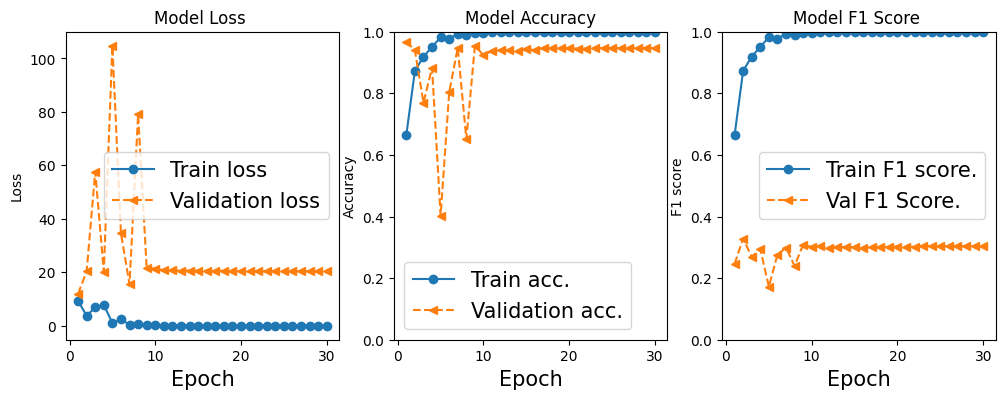

final train acc: 1.000
final val acc:   0.947

Percent Diff in Acc. 5.30%
test_label length :  66352
predicted_labels length :  66352
confusion matrix shape= (4, 4)


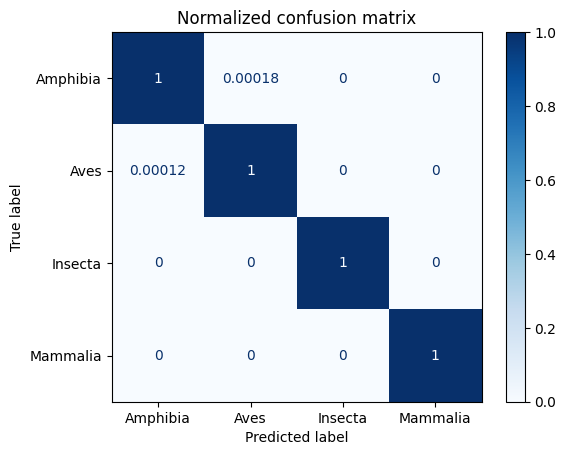

              precision    recall  f1-score   support

    Amphibia       1.00      1.00      1.00     16588
        Aves       1.00      1.00      1.00     16588
     Insecta       1.00      1.00      1.00     16588
    Mammalia       1.00      1.00      1.00     16588

    accuracy                           1.00     66352
   macro avg       1.00      1.00      1.00     66352
weighted avg       1.00      1.00      1.00     66352



In [43]:
#Augment Non-Majority class data with SMOTE resampling

x_smote, y_smote = add_smote_augmentation(X_common_train, y_class_train)

# Rerun Model 2 with augmented data

class_model_2_augm = build_functional_model_2(x_smote.shape[1],y_smote.shape[1])

# train model on (x_smote, y_smote) data
history = class_model_2_augm.fit(
    x_smote,
    y_smote,
    validation_data=(X_common_val,y_class_val),
    callbacks=[reduce_lr_f1],
    epochs=30)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_2_augm, x_smote, y_smote)


#### Resampling using ADASYN

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (66383, 4096)
After augmentation: y shape: (66383, 4)
Reshaped X_resampled :  (66383, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5831 - f1_score: 0.5825 - loss: 14.6127 - val_accuracy: 0.7135 - val_f1_score: 0.2642 - val_loss: 2.0340 - learning_rate: 0.1000
Epoch 2/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8854 - f1_score: 0.8857 - loss: 4.9622 - val_accuracy: 0.8041 - val_f1_score: 0.2678 - val_loss: 77.5125 - learning_rate: 0.1000
Epoch 3/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9339 - f1_score: 0.9342 - loss: 6.8045 - val_accuracy: 0.9424 - val_f1_score: 0.3338 - val_loss: 2.4518 - learning_rate: 0.1000
Epoch 4/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9395 - f1_score: 0.9397 - loss: 14.6858 - val_accuracy: 0.9615 - val_f1_score: 0.2823 - val_loss: 8.4527 - learning_rate: 0.1000
Epoch 5/20
2067/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9544 - f1_score: 0.9546 - loss: 8.5579
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
2075/2075 ━━━━━━━━━━━━━

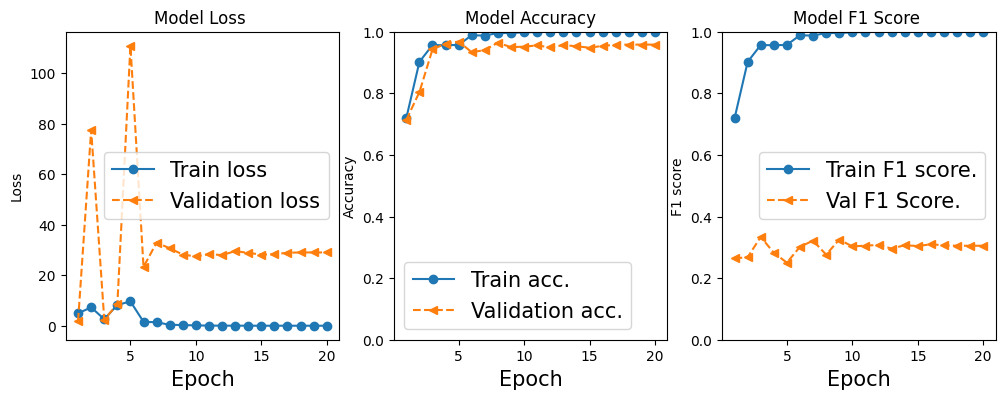

final train acc: 1.000
final val acc:   0.958

Percent Diff in Acc. 4.18%
test_label length :  66383
predicted_labels length :  66383
confusion matrix shape= (4, 4)


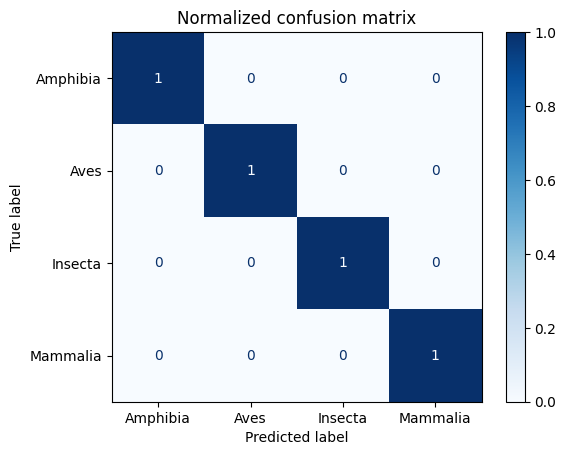

              precision    recall  f1-score   support

    Amphibia       1.00      1.00      1.00     16665
        Aves       1.00      1.00      1.00     16588
     Insecta       1.00      1.00      1.00     16593
    Mammalia       1.00      1.00      1.00     16537

    accuracy                           1.00     66383
   macro avg       1.00      1.00      1.00     66383
weighted avg       1.00      1.00      1.00     66383



In [44]:
#Augment Non-Majority class data with ADASYN resampling

x_adasyn, y_adasyn = add_adasyn_augmentation(X_common_train, y_class_train)

# Rerun Model 2 with augmented data

class_model_2_augm = build_functional_model_2(x_adasyn.shape[1],y_adasyn.shape[1])

# train model on (x_adasyn, y_adasyn) data
history = class_model_2_augm.fit(
    x_adasyn,
    y_adasyn,
    validation_data=(X_common_val,y_class_val),
    callbacks=[reduce_lr_f1],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_2_augm, x_adasyn, y_adasyn)

#### UnderSampling

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (643, 4096)
After augmentation: y shape: (643, 4)
Reshaped X_undersampled :  (643, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.3751 - f1_score: 0.2833 - loss: 192.6287 - val_accuracy: 0.0203 - val_f1_score: 0.0100 - val_loss: 5337.0518 - learning_rate: 0.1000
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4100 - f1_score: 0.2689 - loss: 90.8144 - val_accuracy: 0.0366 - val_f1_score: 0.0408 - val_loss: 193.7083 - learning_rate: 0.1000
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4737 - f1_score: 0.3173 - loss: 26.2978 - val_accuracy: 0.0623 - val_f1_score: 0.0418 - val_loss: 43.7745 - learning_rate: 0.1000
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5187 - f1_score: 0.3621 - loss: 9.4946 - val_accuracy: 0.0403 - val_f1_score: 0.0307 - val_loss: 23.3809 - learning_rate: 0.1000
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4787 - f1_score: 0.3763 - loss: 6.5767 - val_accuracy: 0.1649 - val_f1_score: 0.0900 - val_loss: 10.2894 - learning_rate: 0.1000
Epoch 6/20
21/21 

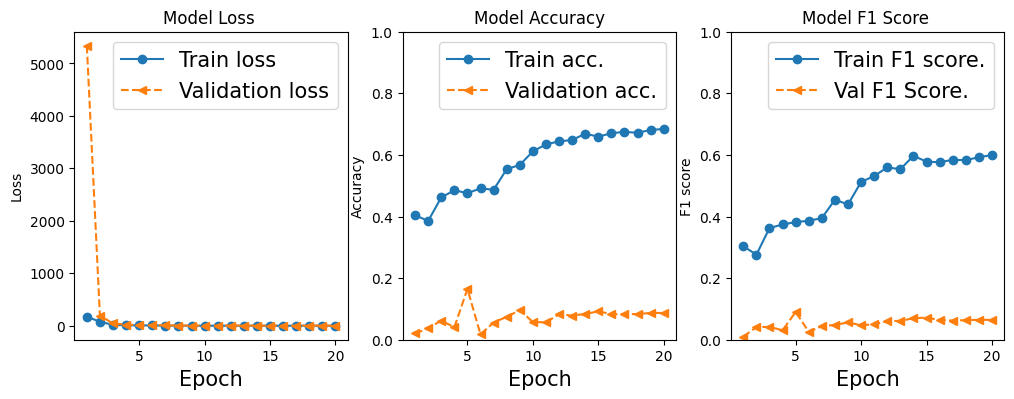

final train acc: 0.684
final val acc:   0.087

Unable to calculate percent diff as Train accuracy is zero
test_label length :  643
predicted_labels length :  643
confusion matrix shape= (4, 4)


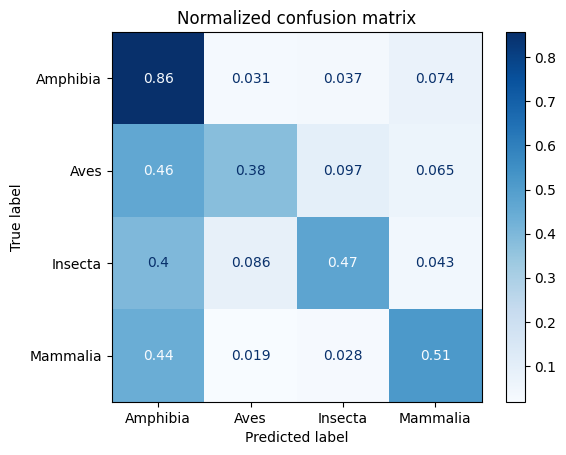

              precision    recall  f1-score   support

    Amphibia       0.70      0.86      0.77       350
        Aves       0.62      0.38      0.47        93
     Insecta       0.64      0.47      0.54        93
    Mammalia       0.60      0.51      0.56       107

    accuracy                           0.67       643
   macro avg       0.64      0.56      0.59       643
weighted avg       0.67      0.67      0.66       643



In [45]:
#Undersampling NearMiss


X_under_nearmiss, y_under_nearmiss = create_undersampled_data(X_common_train, y_class_train,undersampl_type=1)

# Rerun Model 2 with augmented data

class_model_2_augm = build_functional_model_2(X_under_nearmiss.shape[1],y_under_nearmiss.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_augm.fit(
    X_under_nearmiss,
    y_under_nearmiss,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_2_augm, X_under_nearmiss, y_under_nearmiss)

Before augmentation: X shape: (17138, 64, 64, 1)
Before augmentation: y shape: (17138, 4)
Reshaped train data :  (17138, 4096)
After augmentation: X shape: (909, 4096)
After augmentation: y shape: (909, 4)
Reshaped X_undersampled :  (909, 64, 64, 1)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.3331 - f1_score: 0.2601 - loss: 160.1225 - val_accuracy: 0.2072 - val_f1_score: 0.0963 - val_loss: 189.0799 - learning_rate: 0.1000
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3817 - f1_score: 0.3077 - loss: 48.1800 - val_accuracy: 0.3417 - val_f1_score: 0.1443 - val_loss: 26.2702 - learning_rate: 0.1000
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4124 - f1_score: 0.3396 - loss: 20.5550 - val_accuracy: 0.0572 - val_f1_score: 0.0314 - val_loss: 12.5484 - learning_rate: 0.1000
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4411 - f1_score: 0.3577 - loss: 6.0570 - val_accuracy: 0.7073 - val_f1_score: 0.2393 - val_loss: 1.3759 - learning_rate: 0.1000
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4344 - f1_score: 0.3599 - loss: 4.3135 - val_accuracy: 0.8572 - val_f1_score: 0.2469 - val_loss: 0.4974 - learning_rate: 0.1000
Epoch 6/30
29/29 ━━━━

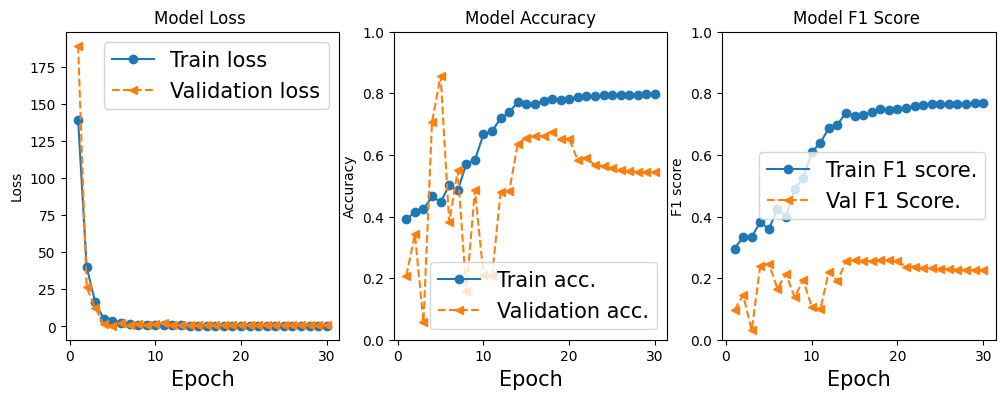

final train acc: 0.799
final val acc:   0.545

Unable to calculate percent diff as Train accuracy is zero
test_label length :  909
predicted_labels length :  909
confusion matrix shape= (4, 4)


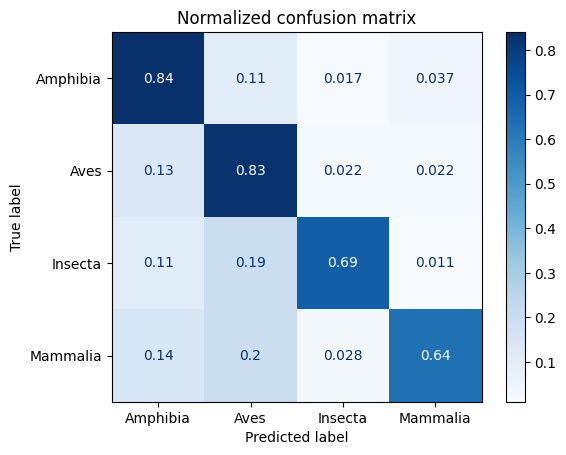

              precision    recall  f1-score   support

    Amphibia       0.81      0.84      0.82       350
        Aves       0.80      0.83      0.81       359
     Insecta       0.79      0.69      0.74        93
    Mammalia       0.76      0.64      0.69       107

    accuracy                           0.80       909
   macro avg       0.79      0.75      0.76       909
weighted avg       0.79      0.80      0.79       909



In [46]:
#Undersampling CondensedNearestNeighbor(CNN)


X_under_cnn, y_under_cnn = create_undersampled_data(X_common_train, y_class_train,undersampl_type=2)


# Rerun Model 2 with augmented data

class_model_2_augm = build_functional_model_2(X_under_cnn.shape[1],y_under_cnn.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_augm.fit(
    X_under_cnn,
    y_under_cnn,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    epochs=30)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_2_augm, X_under_cnn, y_under_cnn)

#### Spectrogram Augmentation

In [47]:
#add_spectrogram_augmentation to data


X_spec_augm, y_spec_augm = add_spectrogram_augmentation(X_common_train, y_class_train)

Reshaped spectrogram shape :  (17138, 64, 64)
Augmented spectrograms shape:  (17138, 64, 64)
Reshaped Augmented spectrograms shape:  (17138, 64, 64, 1)
After augmentation: X shape: (34276, 64, 64, 1)
After augmentation: y shape: (34276, 4)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2731 - f1_score: 0.1213 - loss: 242.4092 - val_accuracy: 0.0124 - val_f1_score: 0.0200 - val_loss: 48.8018 - learning_rate: 0.1000
Epoch 2/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2704 - f1_score: 0.1208 - loss: 78.3506 - val_accuracy: 0.0201 - val_f1_score: 0.0241 - val_loss: 94.7939 - learning_rate: 0.1000
Epoch 3/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2761 - f1_score: 0.1231 - loss: 34.0755 - val_accuracy: 0.0203 - val_f1_score: 0.0366 - val_loss: 63.1309 - learning_rate: 0.1000
Epoch 4/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3051 - f1_score: 0.1330 - loss: 181.7338 - val_accuracy: 0.0170 - val_f1_score: 0.0158 - val_loss: 48.8119 - learning_rate: 0.1000
Epoch 5/20
1066/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3266 - f1_score: 0.1422 - loss: 46.0555
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
1072/1072 ━━━━━━━

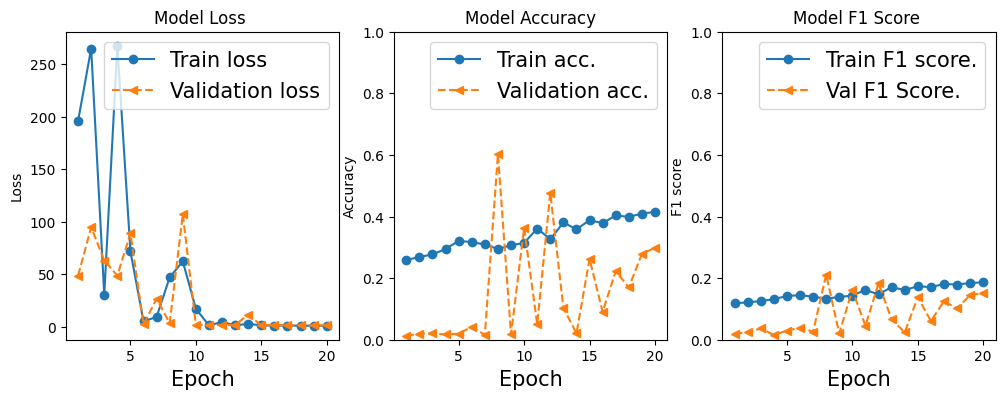

final train acc: 0.415
final val acc:   0.298

Unable to calculate percent diff as Train accuracy is zero
test_label length :  34276
predicted_labels length :  34276
confusion matrix shape= (4, 4)


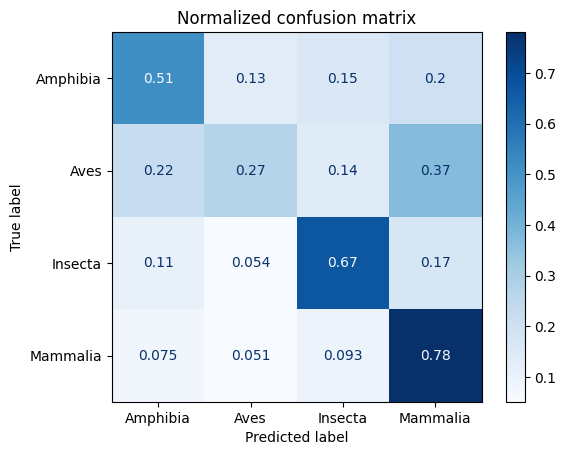

              precision    recall  f1-score   support

    Amphibia       0.05      0.51      0.08       700
        Aves       0.99      0.27      0.42     33176
     Insecta       0.03      0.67      0.05       186
    Mammalia       0.01      0.78      0.03       214

    accuracy                           0.28     34276
   macro avg       0.27      0.56      0.15     34276
weighted avg       0.96      0.28      0.41     34276



In [48]:


# Rerun Model 2 with augmented data

class_model_2_spec_augm = build_functional_model_2(X_spec_augm.shape[1],y_spec_augm.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_spec_augm.fit(
    X_spec_augm,
    y_spec_augm,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    class_weight=class_weights_dict,
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_2_spec_augm, X_spec_augm, y_spec_augm)

#### Spec Augm plus Undersampling NearMiss

Reshaped spectrogram shape :  (643, 64, 64)
Augmented spectrograms shape:  (643, 64, 64)
Reshaped Augmented spectrograms shape:  (643, 64, 64, 1)
After augmentation: X shape: (1286, 64, 64, 1)
After augmentation: y shape: (1286, 4)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.3805 - f1_score: 0.3037 - loss: 122.6776 - val_accuracy: 0.0060 - val_f1_score: 0.0085 - val_loss: 272.0566 - learning_rate: 0.1000
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3909 - f1_score: 0.2851 - loss: 20.1141 - val_accuracy: 0.1474 - val_f1_score: 0.0738 - val_loss: 9.6662 - learning_rate: 0.1000
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4374 - f1_score: 0.3277 - loss: 7.6953 - val_accuracy: 0.0641 - val_f1_score: 0.0426 - val_loss: 6.4219 - learning_rate: 0.1000
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4403 - f1_score: 0.3382 - loss: 4.4152 - val_accuracy: 0.5524 - val_f1_score: 0.2052 - val_loss: 2.1150 - learning_rate: 0.1000
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4726 - f1_score: 0.3750 - loss: 3.6812 - val_accuracy: 0.4054 - val_f1_score: 0.1862 - val_loss: 2.7313 - learning_rate: 0.1000
Epoch 6/20
33/41 ━━━━━━━

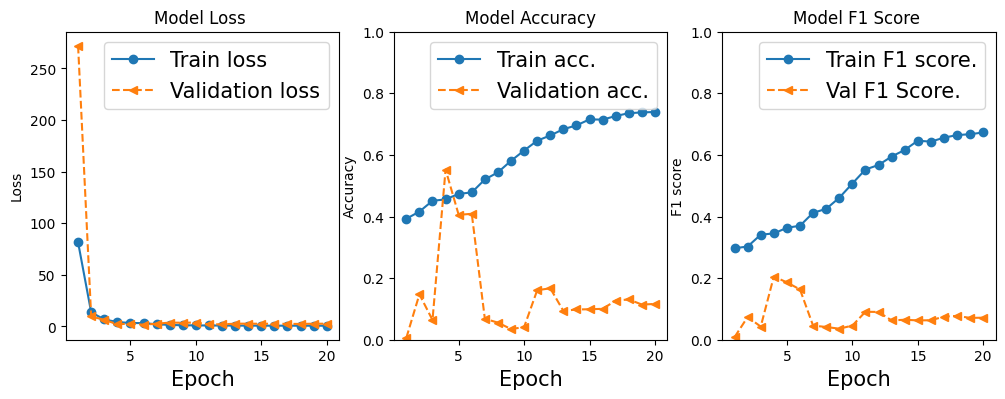

final train acc: 0.740
final val acc:   0.116

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1286
predicted_labels length :  1286
confusion matrix shape= (4, 4)


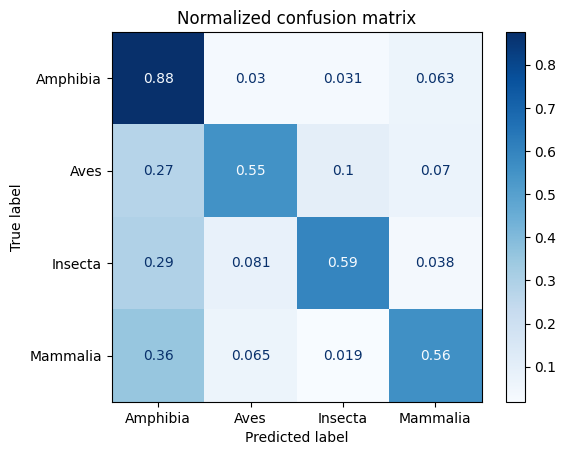

              precision    recall  f1-score   support

    Amphibia       0.77      0.88      0.82       700
        Aves       0.67      0.55      0.61       186
     Insecta       0.71      0.59      0.65       186
    Mammalia       0.65      0.56      0.60       214

    accuracy                           0.74      1286
   macro avg       0.70      0.65      0.67      1286
weighted avg       0.73      0.74      0.73      1286



In [49]:
X_under_1_specaugm, y_under_1_specaugm = add_spectrogram_augmentation(X_under_nearmiss, y_under_nearmiss)

# Rerun Model 2 with augmented data

class_model_2_augm = build_functional_model_2(X_under_1_specaugm.shape[1],y_under_1_specaugm.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_augm.fit(
    X_under_1_specaugm,
    y_under_1_specaugm,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_2_augm, X_under_1_specaugm, y_under_1_specaugm)

#### Spec Augm plus Undersampling CNN

Reshaped spectrogram shape :  (909, 64, 64)
Augmented spectrograms shape:  (909, 64, 64)
Reshaped Augmented spectrograms shape:  (909, 64, 64, 1)
After augmentation: X shape: (1818, 64, 64, 1)
After augmentation: y shape: (1818, 4)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.3531 - f1_score: 0.2837 - loss: 136.8169 - val_accuracy: 0.0075 - val_f1_score: 0.0172 - val_loss: 52.1341 - learning_rate: 0.1000
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3766 - f1_score: 0.3098 - loss: 8.0449 - val_accuracy: 0.1316 - val_f1_score: 0.0699 - val_loss: 4.4038 - learning_rate: 0.1000
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4500 - f1_score: 0.3779 - loss: 2.8730 - val_accuracy: 0.6732 - val_f1_score: 0.2170 - val_loss: 0.8965 - learning_rate: 0.1000
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4408 - f1_score: 0.3574 - loss: 2.4390 - val_accuracy: 0.2542 - val_f1_score: 0.1182 - val_loss: 1.9122 - learning_rate: 0.1000
Epoch 5/20
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4601 - f1_score: 0.3795 - loss: 2.2685
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - a

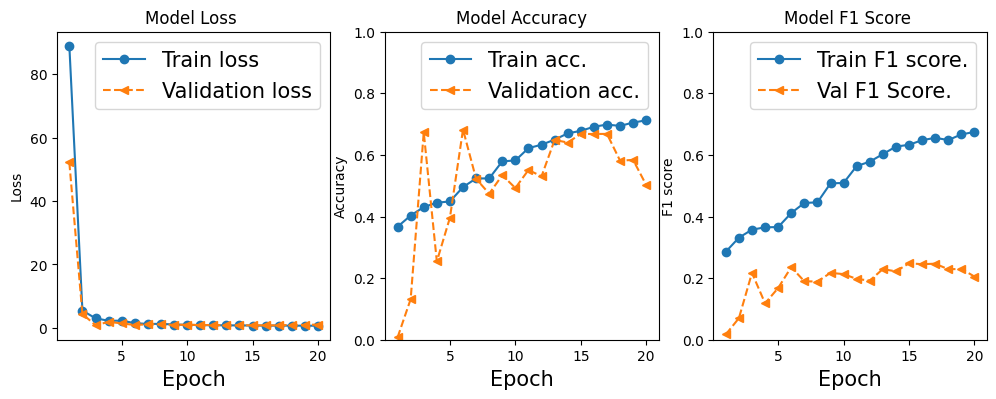

final train acc: 0.712
final val acc:   0.502

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


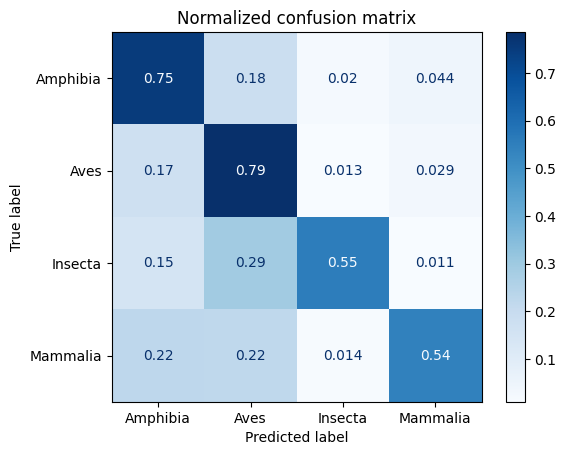

              precision    recall  f1-score   support

    Amphibia       0.73      0.75      0.74       700
        Aves       0.71      0.79      0.75       718
     Insecta       0.80      0.55      0.65       186
    Mammalia       0.68      0.54      0.60       214

    accuracy                           0.72      1818
   macro avg       0.73      0.66      0.69      1818
weighted avg       0.72      0.72      0.72      1818



In [50]:


X_under_2_specaugm, y_under_2_specaugm = add_spectrogram_augmentation(X_under_cnn, y_under_cnn)

# Rerun Model 2 with augmented data

class_model_2_augm = build_functional_model_2(X_under_2_specaugm.shape[1],y_under_2_specaugm.shape[1])

# train model on (X_train, y_train) data
history = class_model_2_augm.fit(
    X_under_2_specaugm,
    y_under_2_specaugm,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    epochs=20)

# plot loss curves
show_history(history)

# plot confusion matrix
plot_confusion_matrix(class_model_2_augm, X_under_2_specaugm, y_under_2_specaugm)


#### Summary of Augmentation


|Class Wghts|Augm Type|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro F1|Avg. Accuracy|Mammalia Recall|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|No|Over-Smote|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|1.00|1.00|1.00|
|No|Over-Adasyn|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|1.00|1.00|1.00|
|No|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|
|No|Under-CNN|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.64|0.69|0.42|
|No|Spec-Augm|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.07|0.25|0.11|
|No|Under-NearMiss-Augm|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.59|0.68|0.43|
|No|Under-CNN-Augm|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.10|0.25|0.14|

##  Hypertuning Model Parmeters

So far, we have attempted the following:  
- different model depths,
- data oversampling,
- data undersampling,
- data augmentation

Next, we will attempt the following Hyperparameter tuning  using Model 2 with CondensedNearestNeighbor UnderSampling as starting point.


|Augm Type|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro F1|Accuracy|
|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|16|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|RMSProp|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|SGD|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.01|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.001|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.4|0.1|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.3|0.1|Adam|32|||
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.2|0.1|Adam|32|||


In [51]:
def build_model_tuning_model_1(img_size, output_size, **kwargs):
  """ Model will be based on model 2 with configurable hyper parameters to aid tuninig
  """
  #set defaults
  maxpool=2
  learn_rate=0.1
  kernel=4
  optimizer='Adam'

  keys = kwargs.keys()
  for key in keys:
    if key == 'maxpool': maxpool=kwargs['maxpool']
    if key == 'learn_rate': learn_rate=kwargs['learn_rate']
    if key == 'kernel': kernel=kwargs['kernel']
    if key == 'optimizer': optimizer=kwargs['optimizer']


  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)


   # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=32,
      kernel_size=(kernel,kernel),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 64,
      kernel_size=(kernel,kernel),
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((maxpool,maxpool))(normal_2)

  flat_1 = tf.keras.layers.Flatten()(maxpool_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')


  # compile model
  if optimizer == "Adam":
    opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  elif optimizer == "RMSprop":
    opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=learn_rate)
  model.compile(
      optimizer=opt,
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=[tf.keras.metrics.Accuracy(),
               tf.keras.metrics.F1Score(average="macro")])

  #print(model.summary())
  return model

In [52]:
def evaluate_tuning_model_1(train_data,
                            label_data,
                            batch='default',
                            maxpool='default',
                            learn_rate='default',
                            kernel='default',
                            optimizer='default'):
  """ Build and Train model based on input parameters and display results
  """
  print(f"Running Tuning model with parameter values: " ,
          f" \nbatch={batch} \nmaxpool={maxpool} \nlearn_rate={learn_rate} \nkernel={kernel} \noptimizer={optimizer}"  )

  if maxpool != 'default':
    print("Tuning maxpool")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     maxpool=maxpool)
  elif learn_rate != 'default':
    print("Tuning learn_rate")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     learn_rate=learn_rate)
  elif kernel != 'default':
    print("Tuning kernel")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     kernel=kernel)
  elif optimizer != 'default':
    print("Tuning optimizer")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1],
                                     optimizer=optimizer)
  else:
    print("Tuning Batch Size")
    model = build_model_tuning_model_1(train_data.shape[1],
                                     label_data.shape[1])

  # train model on (X_train, y_train) data
  if batch == 'default': batch = 32
  history = model.fit(
      train_data,
      label_data,
      validation_data=(X_common_val,y_class_val),
      callbacks=[ reduce_lr_f1],
      batch_size=batch,
      epochs=30)

  # plot loss curves
  show_history(history)

  #plot confusion matrix
  plot_confusion_matrix(model, train_data, label_data)
  return model

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
kernel=2 
optimizer=default
Tuning kernel
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.3993 - f1_score: 0.2768 - loss: 117.8802 - val_accuracy: 0.0569 - val_f1_score: 0.0172 - val_loss: 30.5851 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0135 - f1_score: 0.3465 - loss: 8.0844 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 0.3218 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - f1_score: 0.3972 - loss: 2.2446 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2437 - val_loss: 0.5895 - learning_rate: 0.1000
Epoch 4/30
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - f1_score: 0.4182 - loss: 1.8943
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - f1_score: 0.4172 - 

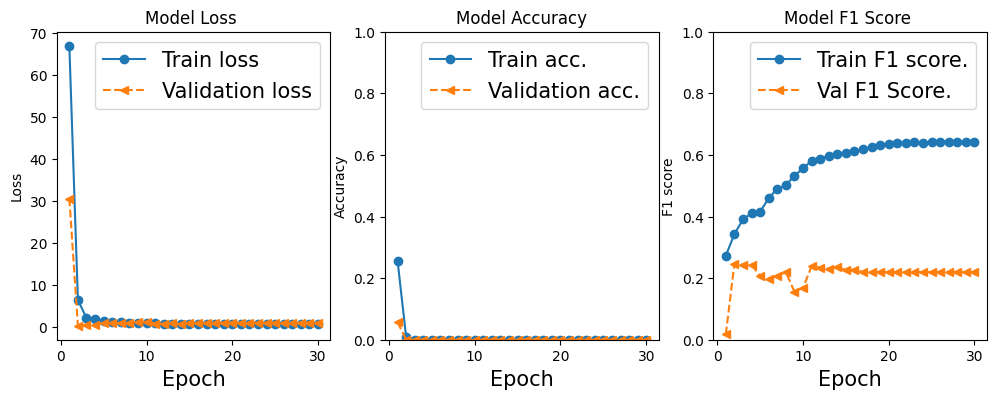

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


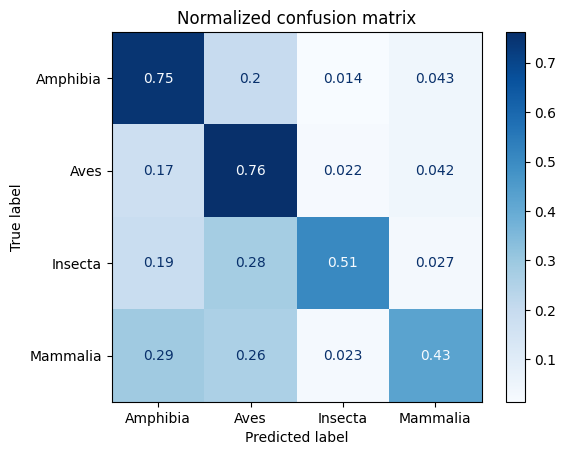

              precision    recall  f1-score   support

    Amphibia       0.70      0.75      0.72       700
        Aves       0.69      0.76      0.72       718
     Insecta       0.75      0.51      0.60       186
    Mammalia       0.58      0.43      0.49       214

    accuracy                           0.69      1818
   macro avg       0.68      0.61      0.64      1818
weighted avg       0.69      0.69      0.68      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
kernel=4 
optimizer=default
Tuning kernel
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.3705 - f1_score: 0.2962 - loss: 106.2271 - val_accuracy: 0.0288 - val_f1_score: 0.0097 - val_loss: 57.3281 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0212 - f1_score: 0.3154 - loss: 8.3950 - val_accuracy: 3.5008e-04 - val_f1_score: 0.1766 - val_loss: 2.6846 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━━━━━━━━━

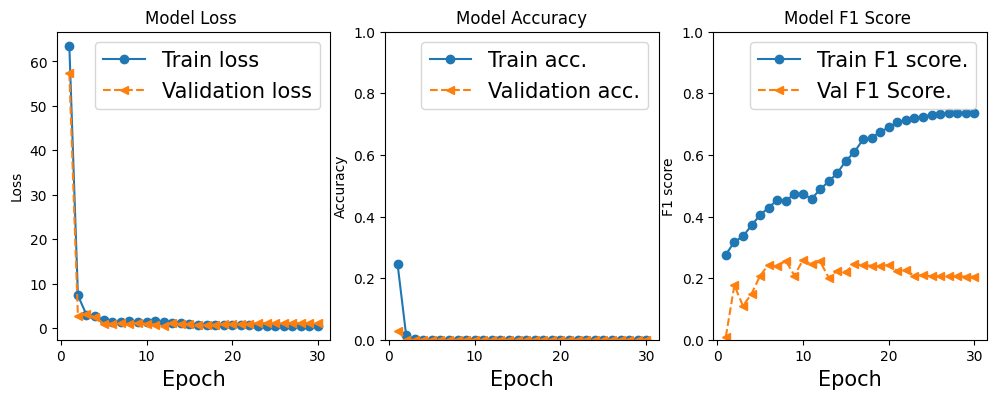

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


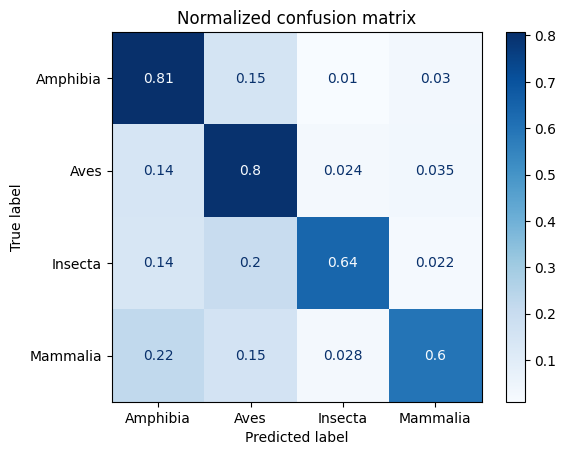

              precision    recall  f1-score   support

    Amphibia       0.76      0.81      0.78       700
        Aves       0.76      0.80      0.78       718
     Insecta       0.80      0.64      0.71       186
    Mammalia       0.72      0.60      0.65       214

    accuracy                           0.76      1818
   macro avg       0.76      0.71      0.73      1818
weighted avg       0.76      0.76      0.76      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
kernel=8 
optimizer=default
Tuning kernel
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.3726 - f1_score: 0.2741 - loss: 111.4406 - val_accuracy: 0.1300 - val_f1_score: 0.0348 - val_loss: 68.6626 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0088 - f1_score: 0.2975 - loss: 7.1393 - val_accuracy: 4.3760e-05 - val_f1_score: 0.1988 - val_loss: 2.4669 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━━━━━━━━━

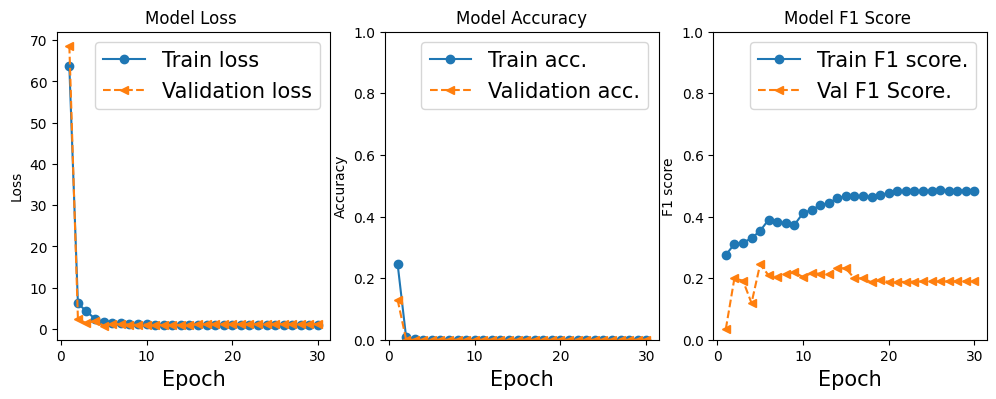

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


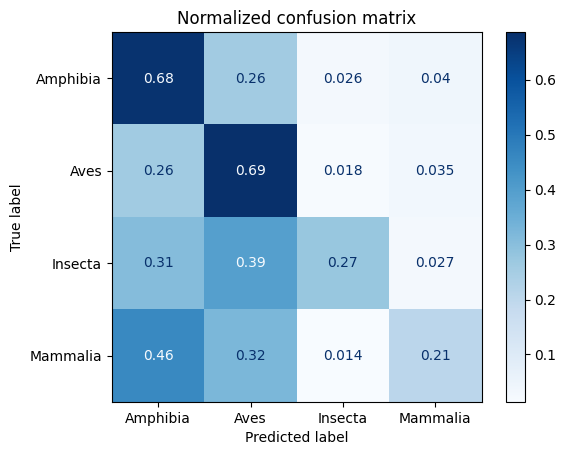

              precision    recall  f1-score   support

    Amphibia       0.58      0.68      0.63       700
        Aves       0.60      0.69      0.64       718
     Insecta       0.60      0.27      0.38       186
    Mammalia       0.43      0.21      0.28       214

    accuracy                           0.58      1818
   macro avg       0.55      0.46      0.48      1818
weighted avg       0.57      0.58      0.57      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=2 
learn_rate=default 
kernel=default 
optimizer=default
Tuning maxpool
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3537 - f1_score: 0.2558 - loss: 119.7965 - val_accuracy: 0.0634 - val_f1_score: 0.0463 - val_loss: 80.0141 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0111 - f1_score: 0.3376 - loss: 6.6906 - val_accuracy: 8.7520e-05 - val_f1_score: 0.0312 - val_loss: 8.2890 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━━━━━━━━

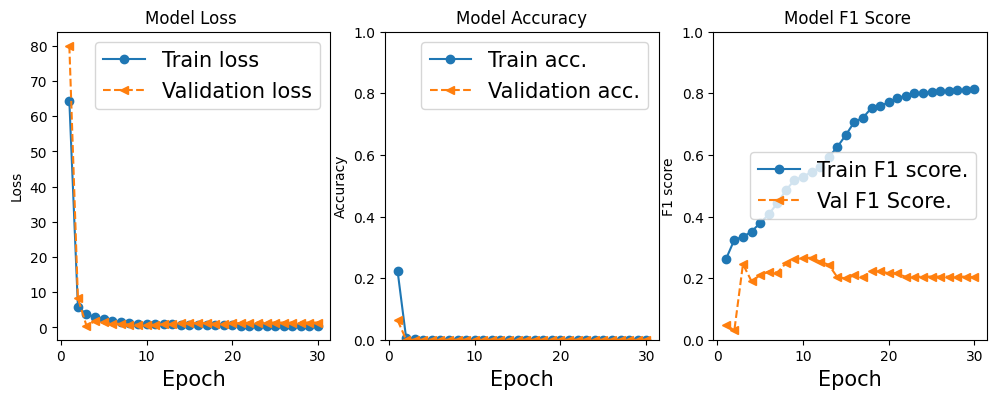

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


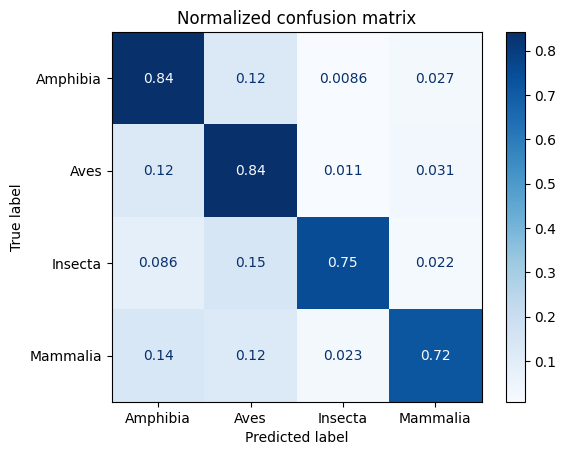

              precision    recall  f1-score   support

    Amphibia       0.82      0.84      0.83       700
        Aves       0.81      0.84      0.82       718
     Insecta       0.88      0.75      0.81       186
    Mammalia       0.77      0.72      0.75       214

    accuracy                           0.82      1818
   macro avg       0.82      0.79      0.80      1818
weighted avg       0.82      0.82      0.81      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=4 
learn_rate=default 
kernel=default 
optimizer=default
Tuning maxpool
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.0832 - f1_score: 0.2658 - loss: 16.2866 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2061 - val_loss: 0.7170 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - f1_score: 0.2526 - loss: 1.8897 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0578 - val_loss: 1.1906 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━━

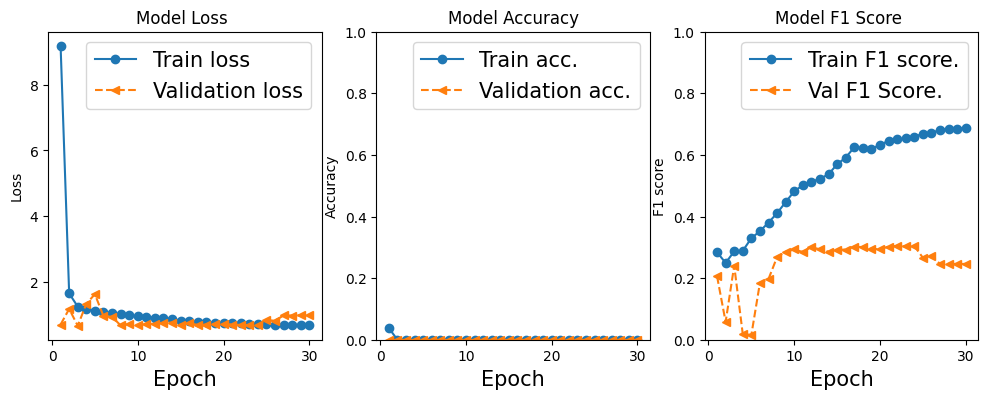

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


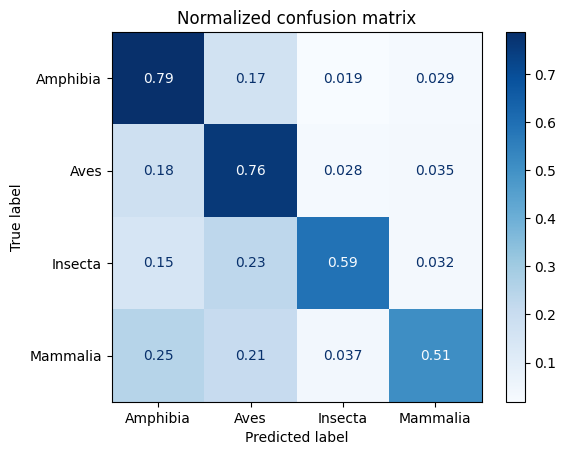

              precision    recall  f1-score   support

    Amphibia       0.73      0.79      0.76       700
        Aves       0.73      0.76      0.74       718
     Insecta       0.73      0.59      0.65       186
    Mammalia       0.68      0.51      0.58       214

    accuracy                           0.72      1818
   macro avg       0.72      0.66      0.68      1818
weighted avg       0.72      0.72      0.72      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=8 
learn_rate=default 
kernel=default 
optimizer=default
Tuning maxpool
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 5.9178e-04 - f1_score: 0.2549 - loss: 3.7591 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0130 - val_loss: 2.6258 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0000e+00 - f1_score: 0.2374 - loss: 1.2311 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0139 - val_loss: 1.5585 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━

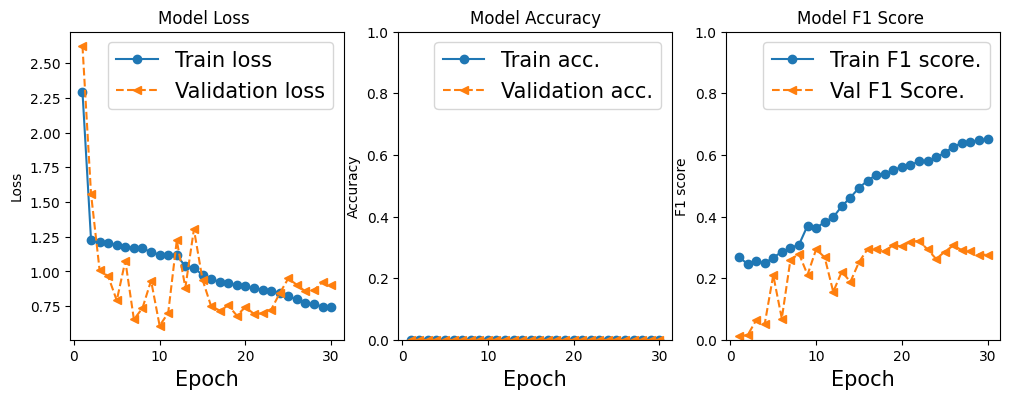

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


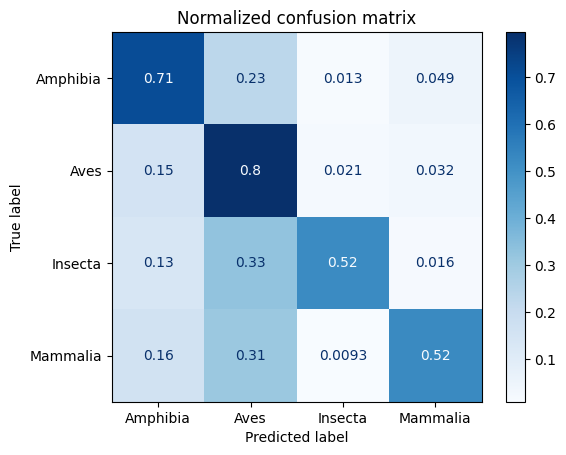

              precision    recall  f1-score   support

    Amphibia       0.75      0.71      0.73       700
        Aves       0.66      0.80      0.72       718
     Insecta       0.79      0.52      0.63       186
    Mammalia       0.65      0.52      0.58       214

    accuracy                           0.70      1818
   macro avg       0.71      0.64      0.66      1818
weighted avg       0.71      0.70      0.70      1818

Running Tuning model with parameter values:   
batch=16 
maxpool=default 
learn_rate=default 
kernel=default 
optimizer=default
Tuning Batch Size
Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.3864 - f1_score: 0.2637 - loss: 122.6622 - val_accuracy: 0.0033 - val_f1_score: 0.1270 - val_loss: 6.8757 - learning_rate: 0.1000
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0185 - f1_score: 0.3208 - loss: 8.4127 - val_accuracy: 0.0065 - val_f1_score: 0.2336 - val_loss: 1.5775 - learning_rate: 0.1000
Epoch 3/30
114/114 ━━━━━━━━

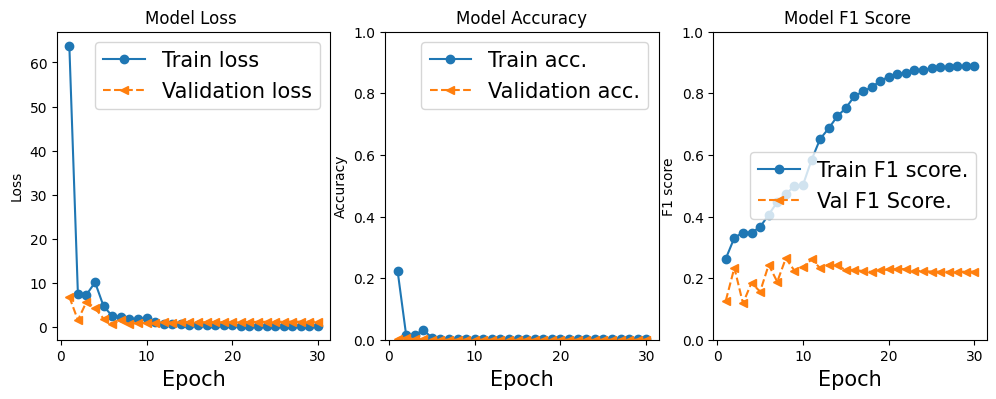

final train acc: 0.002
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


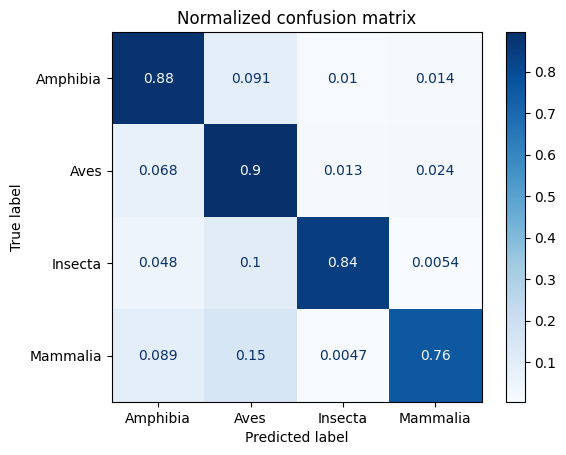

              precision    recall  f1-score   support

    Amphibia       0.89      0.88      0.89       700
        Aves       0.85      0.90      0.87       718
     Insecta       0.90      0.84      0.87       186
    Mammalia       0.85      0.76      0.80       214

    accuracy                           0.87      1818
   macro avg       0.87      0.85      0.86      1818
weighted avg       0.87      0.87      0.87      1818

Running Tuning model with parameter values:   
batch=32 
maxpool=default 
learn_rate=default 
kernel=default 
optimizer=default
Tuning Batch Size
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3747 - f1_score: 0.2728 - loss: 117.7547 - val_accuracy: 0.0373 - val_f1_score: 0.2284 - val_loss: 3.3133 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0054 - f1_score: 0.2668 - loss: 6.3638 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2375 - val_loss: 0.3742 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━━━━━

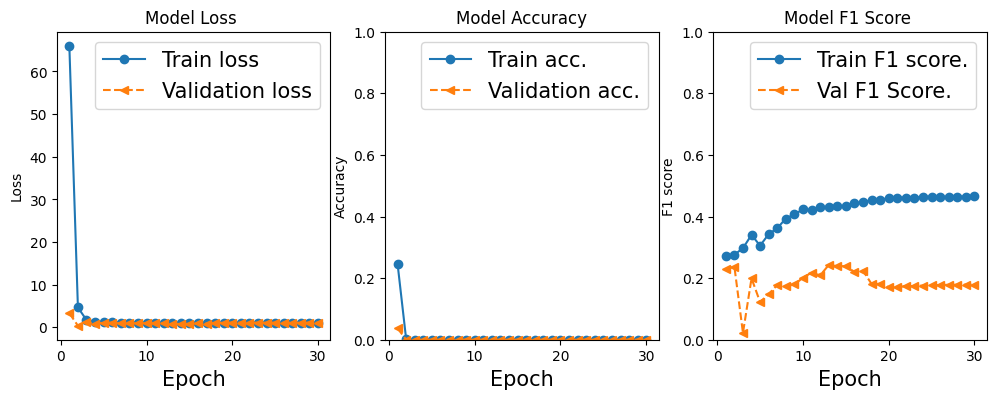

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


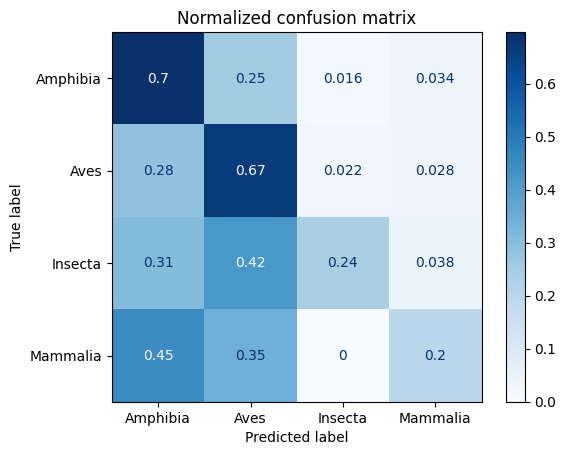

              precision    recall  f1-score   support

    Amphibia       0.58      0.70      0.63       700
        Aves       0.59      0.67      0.63       718
     Insecta       0.62      0.24      0.34       186
    Mammalia       0.46      0.20      0.28       214

    accuracy                           0.58      1818
   macro avg       0.56      0.45      0.47      1818
weighted avg       0.57      0.58      0.56      1818

Running Tuning model with parameter values:   
batch=64 
maxpool=default 
learn_rate=default 
kernel=default 
optimizer=default
Tuning Batch Size
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.4397 - f1_score: 0.2688 - loss: 133.4867 - val_accuracy: 0.2423 - val_f1_score: 0.0185 - val_loss: 307.2705 - learning_rate: 0.1000
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1147 - f1_score: 0.3162 - loss: 21.1534 - val_accuracy: 0.1695 - val_f1_score: 0.0150 - val_loss: 50.5112 - learning_rate: 0.1000
Epoch 3/30
29/29 ━━━━━━━━━

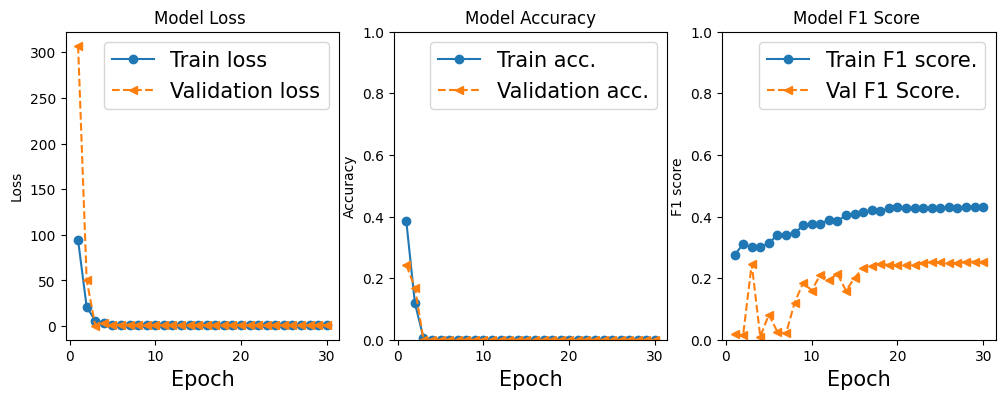

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


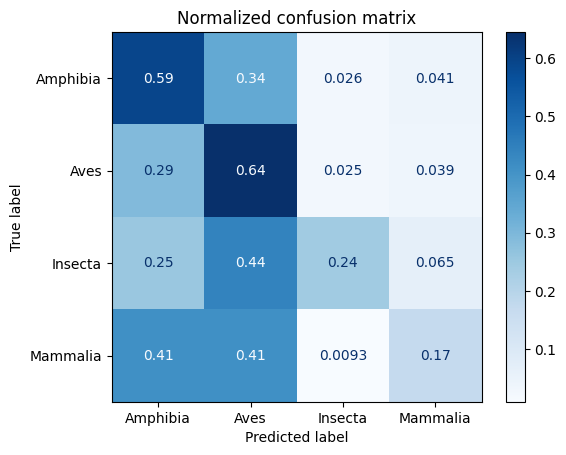

              precision    recall  f1-score   support

    Amphibia       0.55      0.59      0.57       700
        Aves       0.53      0.64      0.58       718
     Insecta       0.54      0.24      0.33       186
    Mammalia       0.34      0.17      0.23       214

    accuracy                           0.53      1818
   macro avg       0.49      0.41      0.43      1818
weighted avg       0.52      0.53      0.51      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
kernel=default 
optimizer=Adam
Tuning optimizer
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.3972 - f1_score: 0.2680 - loss: 127.1914 - val_accuracy: 0.1642 - val_f1_score: 0.0827 - val_loss: 37.1271 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0237 - f1_score: 0.3222 - loss: 8.8091 - val_accuracy: 7.0016e-04 - val_f1_score: 0.1905 - val_loss: 1.9474 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━━━

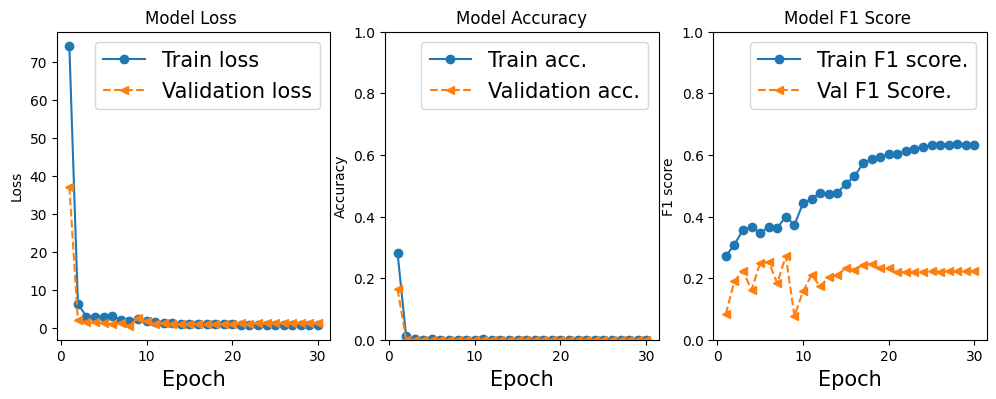

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


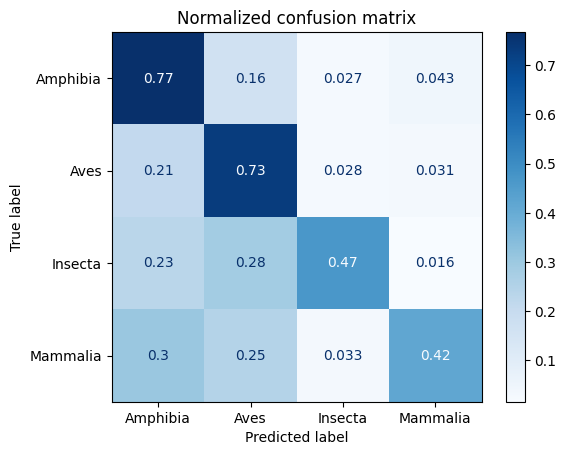

              precision    recall  f1-score   support

    Amphibia       0.67      0.77      0.72       700
        Aves       0.70      0.73      0.72       718
     Insecta       0.65      0.47      0.55       186
    Mammalia       0.62      0.42      0.50       214

    accuracy                           0.68      1818
   macro avg       0.66      0.60      0.62      1818
weighted avg       0.68      0.68      0.67      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
kernel=default 
optimizer=RMSprop
Tuning optimizer
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3885 - f1_score: 0.2375 - loss: 280.0724 - val_accuracy: 0.3267 - val_f1_score: 0.1219 - val_loss: 87.4903 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2674 - f1_score: 0.2554 - loss: 87.3516 - val_accuracy: 0.4244 - val_f1_score: 0.0081 - val_loss: 439.8230 - learning_rate: 0.1000
Epoch 3/30
57/57 ━━━━━━

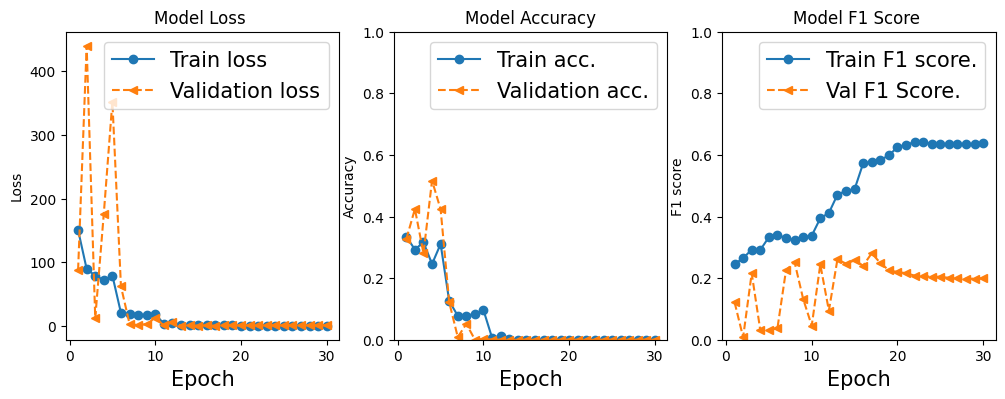

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


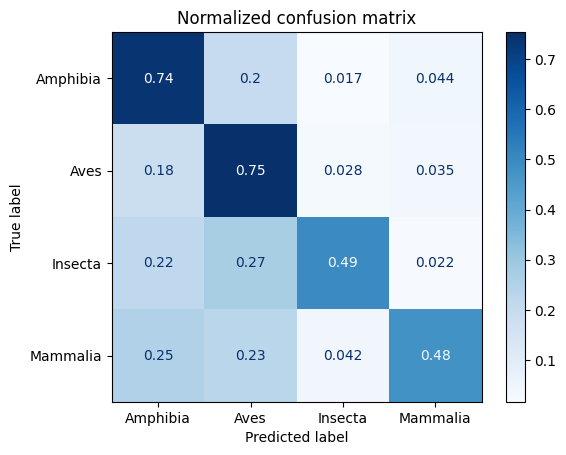

              precision    recall  f1-score   support

    Amphibia       0.70      0.74      0.72       700
        Aves       0.69      0.75      0.72       718
     Insecta       0.69      0.49      0.58       186
    Mammalia       0.63      0.48      0.54       214

    accuracy                           0.69      1818
   macro avg       0.68      0.62      0.64      1818
weighted avg       0.69      0.69      0.68      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=default 
kernel=default 
optimizer=SGD
Tuning optimizer
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5092 - f1_score: 0.2185 - loss: 500963936.0000 - val_accuracy: 0.5032 - val_f1_score: 0.0031 - val_loss: 66514262687744.0000 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6071 - f1_score: 0.1896 - loss: 82766195177675554816.0000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: nan - learning_r

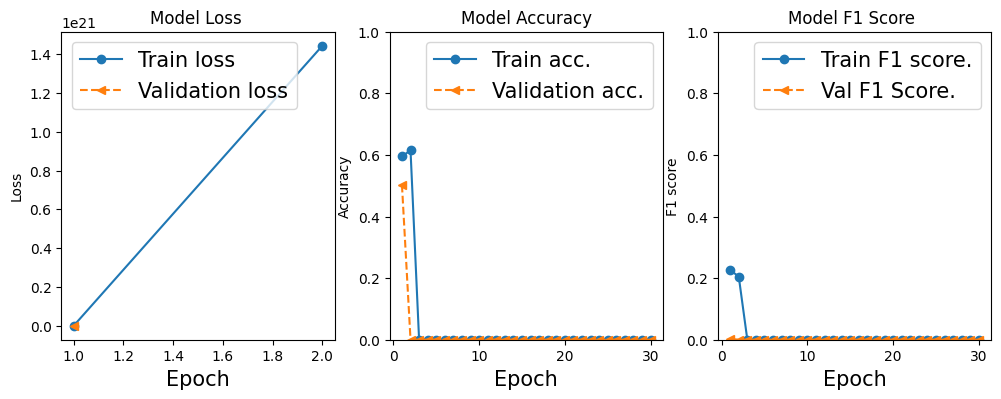

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


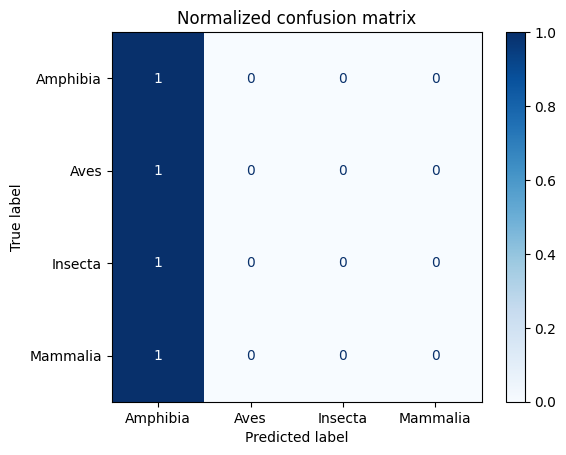

              precision    recall  f1-score   support

    Amphibia       0.39      1.00      0.56       700
        Aves       0.00      0.00      0.00       718
     Insecta       0.00      0.00      0.00       186
    Mammalia       0.00      0.00      0.00       214

    accuracy                           0.39      1818
   macro avg       0.10      0.25      0.14      1818
weighted avg       0.15      0.39      0.21      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=0.1 
kernel=default 
optimizer=default
Tuning learn_rate
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3538 - f1_score: 0.2631 - loss: 126.2738 - val_accuracy: 6.1264e-04 - val_f1_score: 0.0553 - val_loss: 13.1041 - learning_rate: 0.1000
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 5.5478e-04 - f1_score: 0.3208 - loss: 3.7932 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2459 - val_loss: 0.2658 - learning_rate: 0.1000
Epoch 3/30
57/57 

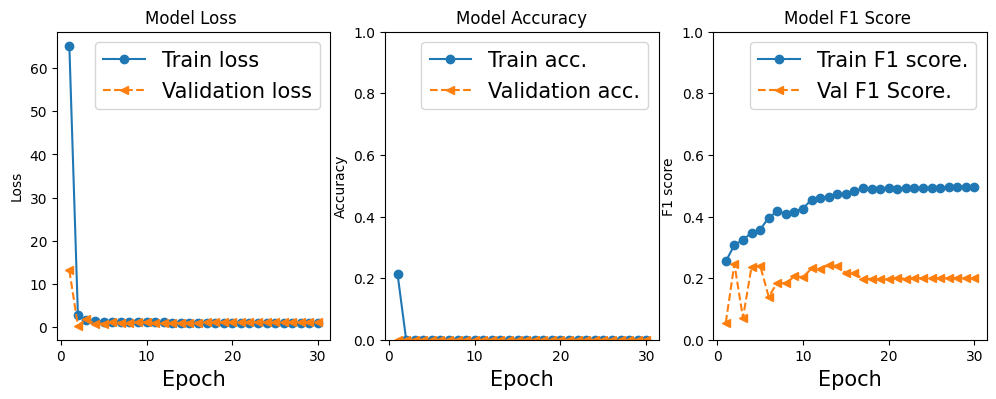

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


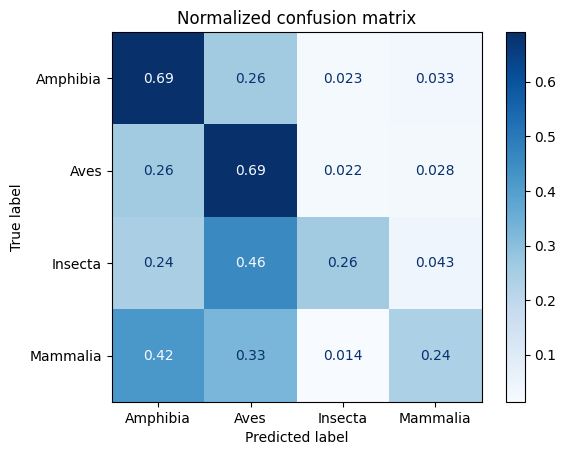

              precision    recall  f1-score   support

    Amphibia       0.60      0.69      0.64       700
        Aves       0.60      0.69      0.64       718
     Insecta       0.58      0.26      0.36       186
    Mammalia       0.50      0.24      0.32       214

    accuracy                           0.59      1818
   macro avg       0.57      0.47      0.49      1818
weighted avg       0.58      0.59      0.57      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=0.01 
kernel=default 
optimizer=default
Tuning learn_rate
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.0908 - f1_score: 0.3013 - loss: 19.7373 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2119 - val_loss: 1.2758 - learning_rate: 0.0100
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0538 - f1_score: 0.3814 - loss: 11.1220 - val_accuracy: 0.0000e+00 - val_f1_score: 0.1666 - val_loss: 1.3902 - learning_rate: 0.0100
Epoch 3/30
57/57 ━━━━

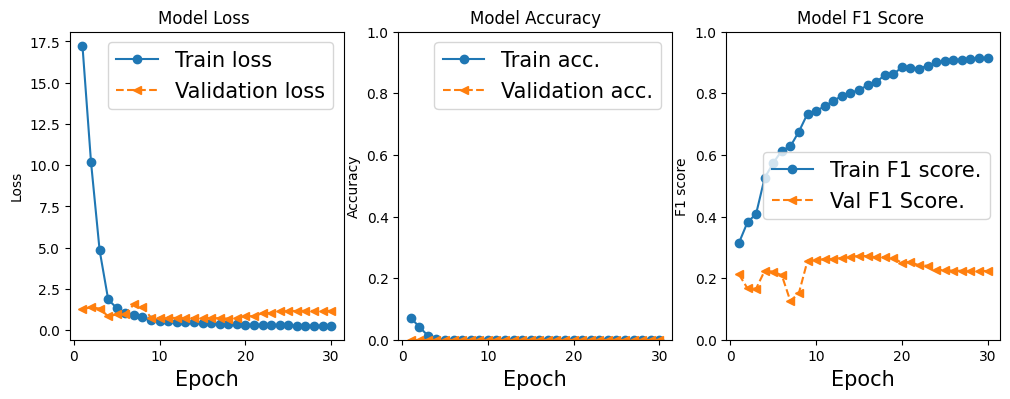

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


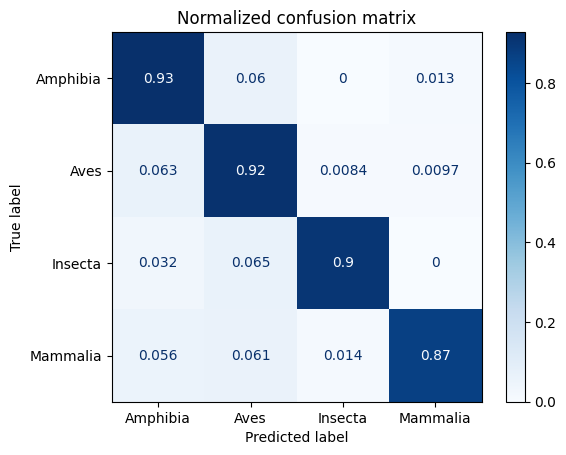

              precision    recall  f1-score   support

    Amphibia       0.91      0.93      0.92       700
        Aves       0.91      0.92      0.91       718
     Insecta       0.95      0.90      0.93       186
    Mammalia       0.92      0.87      0.89       214

    accuracy                           0.91      1818
   macro avg       0.92      0.90      0.91      1818
weighted avg       0.92      0.91      0.91      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=0.001 
kernel=default 
optimizer=default
Tuning learn_rate
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 7.7764e-04 - f1_score: 0.3117 - loss: 3.4343 - val_accuracy: 0.0000e+00 - val_f1_score: 0.0131 - val_loss: 1.5087 - learning_rate: 0.0010
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - f1_score: 0.4849 - loss: 1.7877 - val_accuracy: 0.0000e+00 - val_f1_score: 0.1460 - val_loss: 1.1488 - learning_rate: 0.0010
Epoch 3/30
57/

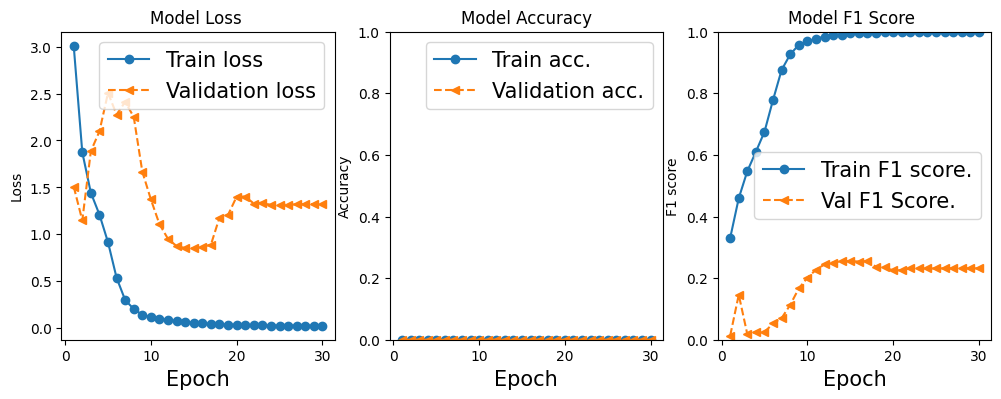

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


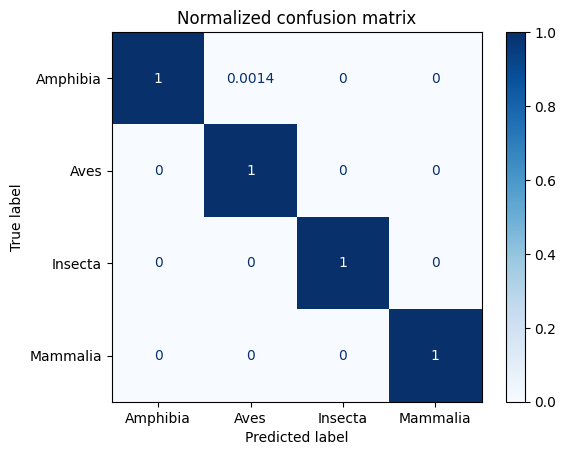

              precision    recall  f1-score   support

    Amphibia       1.00      1.00      1.00       700
        Aves       1.00      1.00      1.00       718
     Insecta       1.00      1.00      1.00       186
    Mammalia       1.00      1.00      1.00       214

    accuracy                           1.00      1818
   macro avg       1.00      1.00      1.00      1818
weighted avg       1.00      1.00      1.00      1818

Running Tuning model with parameter values:   
batch=default 
maxpool=default 
learn_rate=0.0001 
kernel=default 
optimizer=default
Tuning learn_rate
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.0000e+00 - f1_score: 0.2970 - loss: 1.5988 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2661 - val_loss: 1.3053 - learning_rate: 1.0000e-04
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - f1_score: 0.5021 - loss: 1.0040 - val_accuracy: 0.0000e+00 - val_f1_score: 0.2554 - val_loss: 1.1826 - learning_rate: 1.0000e-04
Epoch

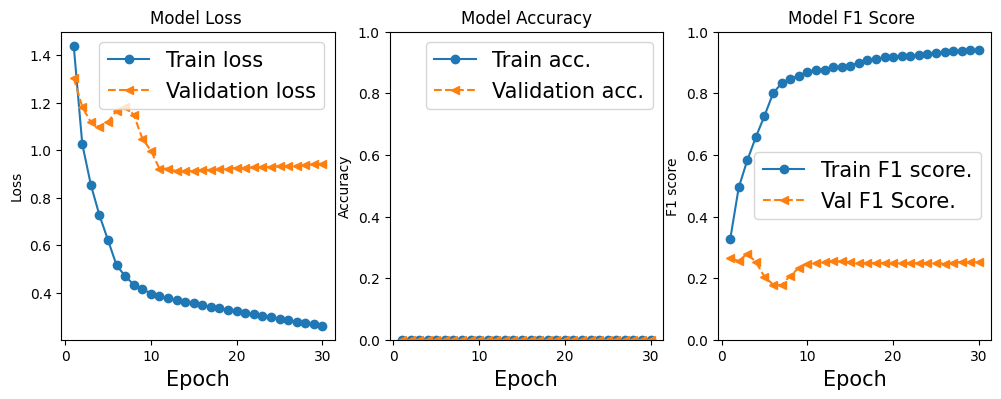

final train acc: 0.000
final val acc:   0.000

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


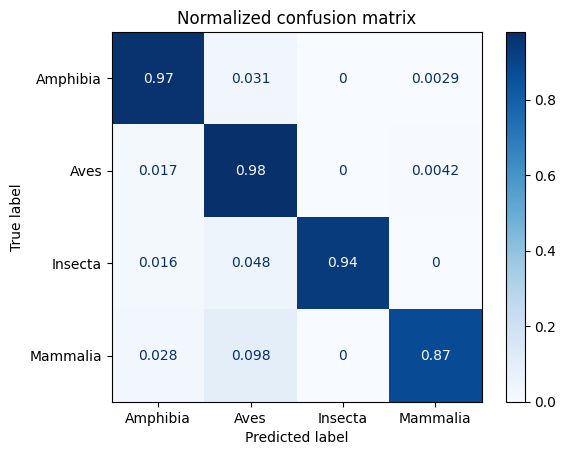

              precision    recall  f1-score   support

    Amphibia       0.97      0.97      0.97       700
        Aves       0.93      0.98      0.95       718
     Insecta       1.00      0.94      0.97       186
    Mammalia       0.97      0.87      0.92       214

    accuracy                           0.96      1818
   macro avg       0.97      0.94      0.95      1818
weighted avg       0.96      0.96      0.96      1818



In [53]:
optimizer_list = ['Adam', 'RMSprop', "SGD"]
learn_rate_list = [0.1, 0.01, 0.001, 0.0001]
kernel_list = [2,4,8]
maxpool_list = [2,4,8]
batch_size_list = [16, 32, 64]


#kernel
for item in kernel_list:
      evaluate_tuning_model_1(X_under_2_specaugm, y_under_2_specaugm, kernel=item)
#Maxpool
for item in maxpool_list:
      evaluate_tuning_model_1(X_under_2_specaugm, y_under_2_specaugm, maxpool=item)


#Batch Size
for item in batch_size_list:
      evaluate_tuning_model_1(X_under_2_specaugm, y_under_2_specaugm, batch=item)
#Optimizer
for item in optimizer_list:
      evaluate_tuning_model_1(X_under_2_specaugm, y_under_2_specaugm, optimizer=item)

#Learn Rate
for item in learn_rate_list:
      evaluate_tuning_model_1(X_under_2_specaugm, y_under_2_specaugm, learn_rate=item)




#### Summary of HyperParameter Tuning


|Augm Type|Model|# Conv|Filters|Stride|kernel|MaxPool|Dropout|L.R.|Optimizer|batch|Macro F1|Avg Accuracy|Mammalia Recall|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Under-NearMiss|2|2|(32,64)|(1,1)|(2,2)|(2,2)|0.5|0.1|Adam|32|0.43|0.56|0.20|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.59|0.67|0.30|
|Under-NearMiss|2|2|(32,64)|(1,1)|(8,8)|(2,2)|0.5|0.1|Adam|32|0.57|0.64|0.34|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.62|0.67|0.49|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(4,4)|0.5|0.1|Adam|32|0.42|0.55|0.14|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(8,8)|0.5|0.1|Adam|32|0.59|0.64|0.46|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|16|0.41|0.55|0.11|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.59|0.65|0.37|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|64|0.58|0.64|0.35|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.45|0.56|0.15|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|RMSProp|32|0.72|0.75|0.61|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|SGD|32|0.14|0.39|0.00|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.1|Adam|32|0.50|0.60|0.22|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.01|Adam|32|0.99|0.99|0.99|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.001|Adam|32|1.00|1.00|1.00|
|Under-NearMiss|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.5|0.0001|Adam|32|0.92|0.93|0.82|

Based on the above data, Under Sampling using CNN appears to give the best performance. Reducing Kernel_size to 4, maxpool to 2, learning rate to 0.01 and using RMSProp optimizer improve macro F1-Score. Changing Batch Size did not appear to improve the performance.

## Model Evaluation


Based on the results from the Tuning, we will select the following parameters for our evaluation with test data.

|Class Weights|Augm Type|Model|# Conv|Filters|Stride|Kernel|MaxPool|Dropout|L.R.|Optimizer|Batch|Macro Precision|Macro Recall|Macro F1|Accuracy|Prediction|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|No|Under-CNN|2|2|(32,64)|(1,1)|(4,4)|(2,2)|0.1|0.01|RMSProp|32||||||

In [54]:
def build_evaluation_model(img_size, output_size):
  """ Train model based on selected parameters and display results
  Using Model_2 which has 2 blocks of convolutional layer followed by MaxPool
  """
  kernel = (4,4)
  l_r = 0.01
  optimizer = 'RMSProp'
  maxpool = (2,2)


  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)


  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=32,
      kernel_size=kernel,
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D(maxpool)(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 64,
      kernel_size=kernel,
      strides=(1,1),
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D(maxpool)(normal_2)

  flat_1 = tf.keras.layers.Flatten()(maxpool_2)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(flat_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=l_r),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model



In [55]:
#Recalculate class weights due to class imbalance

#decode y_under_cnn
print("y_under_2_specaugm shape: ", y_under_2_specaugm.shape)
y_under_2_specaugm_decoded = np.argmax(y_under_cnn, axis=1)
print("y_under_2_specaugm_decoded shape: ", y_under_2_specaugm_decoded.shape)
class_weights_list = compute_class_weight(
                                        class_weight='balanced',
                                        classes=unique_classes,
                                        y=y_under_2_specaugm_decoded)

# Convert to a dictionary for Keras/TensorFlow
under_cnn_class_weights_dict = dict(zip(unique_classes,
                              class_weights_list))

under_cnn_class_weights_dict

y_under_2_specaugm shape:  (1818, 4)
y_under_2_specaugm_decoded shape:  (909,)


{np.int64(0): np.float64(0.6492857142857142),
 np.int64(1): np.float64(0.633008356545961),
 np.int64(2): np.float64(2.443548387096774),
 np.int64(3): np.float64(2.1238317757009346)}

Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.3457 - f1_score: 0.2798 - loss: 50.6634 - val_accuracy: 0.0208 - val_f1_score: 0.0426 - val_loss: 26.6432 - learning_rate: 0.0100
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4251 - f1_score: 0.3614 - loss: 17.6470 - val_accuracy: 0.0060 - val_f1_score: 0.0132 - val_loss: 6.8437 - learning_rate: 0.0100
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4835 - f1_score: 0.4108 - loss: 4.3431 - val_accuracy: 0.6163 - val_f1_score: 0.2145 - val_loss: 1.0256 - learning_rate: 0.0100
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5065 - f1_score: 0.4286 - loss: 1.4345 - val_accuracy: 0.0063 - val_f1_score: 0.0031 - val_loss: 2.7578 - learning_rate: 0.0100
Epoch 5/30
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5642 - f1_score: 0.4758 - loss: 1.1329
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - 

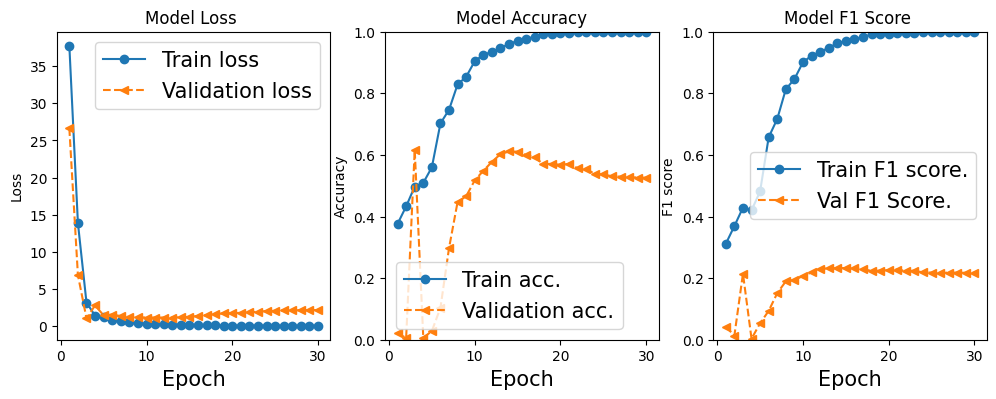

final train acc: 0.999
final val acc:   0.526

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


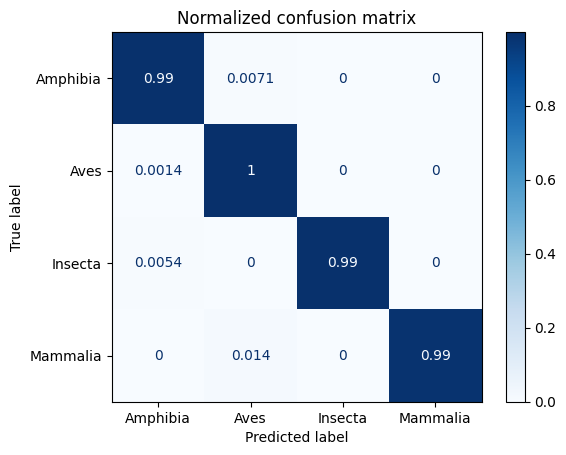

              precision    recall  f1-score   support

    Amphibia       1.00      0.99      0.99       700
        Aves       0.99      1.00      0.99       718
     Insecta       1.00      0.99      1.00       186
    Mammalia       1.00      0.99      0.99       214

    accuracy                           0.99      1818
   macro avg       1.00      0.99      0.99      1818
weighted avg       0.99      0.99      0.99      1818



In [56]:
evaluation_model = build_evaluation_model(X_under_2_specaugm.shape[1],y_under_2_specaugm.shape[1])

# train model on (X_train, y_train) data
history = evaluation_model.fit(
    X_under_2_specaugm,
    y_under_2_specaugm,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    batch_size=32,
    epochs=30)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(evaluation_model, X_under_2_specaugm, y_under_2_specaugm)

In [57]:
result_eval = evaluation_model.evaluate(X_common_test,
                          y_class_test,
                                        return_dict=True)


print("evaluation results = ", result_eval)
print('\nTest Acc. {:.4f}%'.format(result_eval.get('accuracy')*100))
print('\nTest F1-score MACRO. {:.4f}%'.format(result_eval.get('f1_score')*100))



179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5215 - f1_score: 0.2278 - loss: 2.1922
evaluation results =  {'accuracy': 0.5174164175987244, 'f1_score': 0.22471758723258972, 'loss': 2.1808223724365234}

Test Acc. 51.7416%

Test F1-score MACRO. 22.4718%


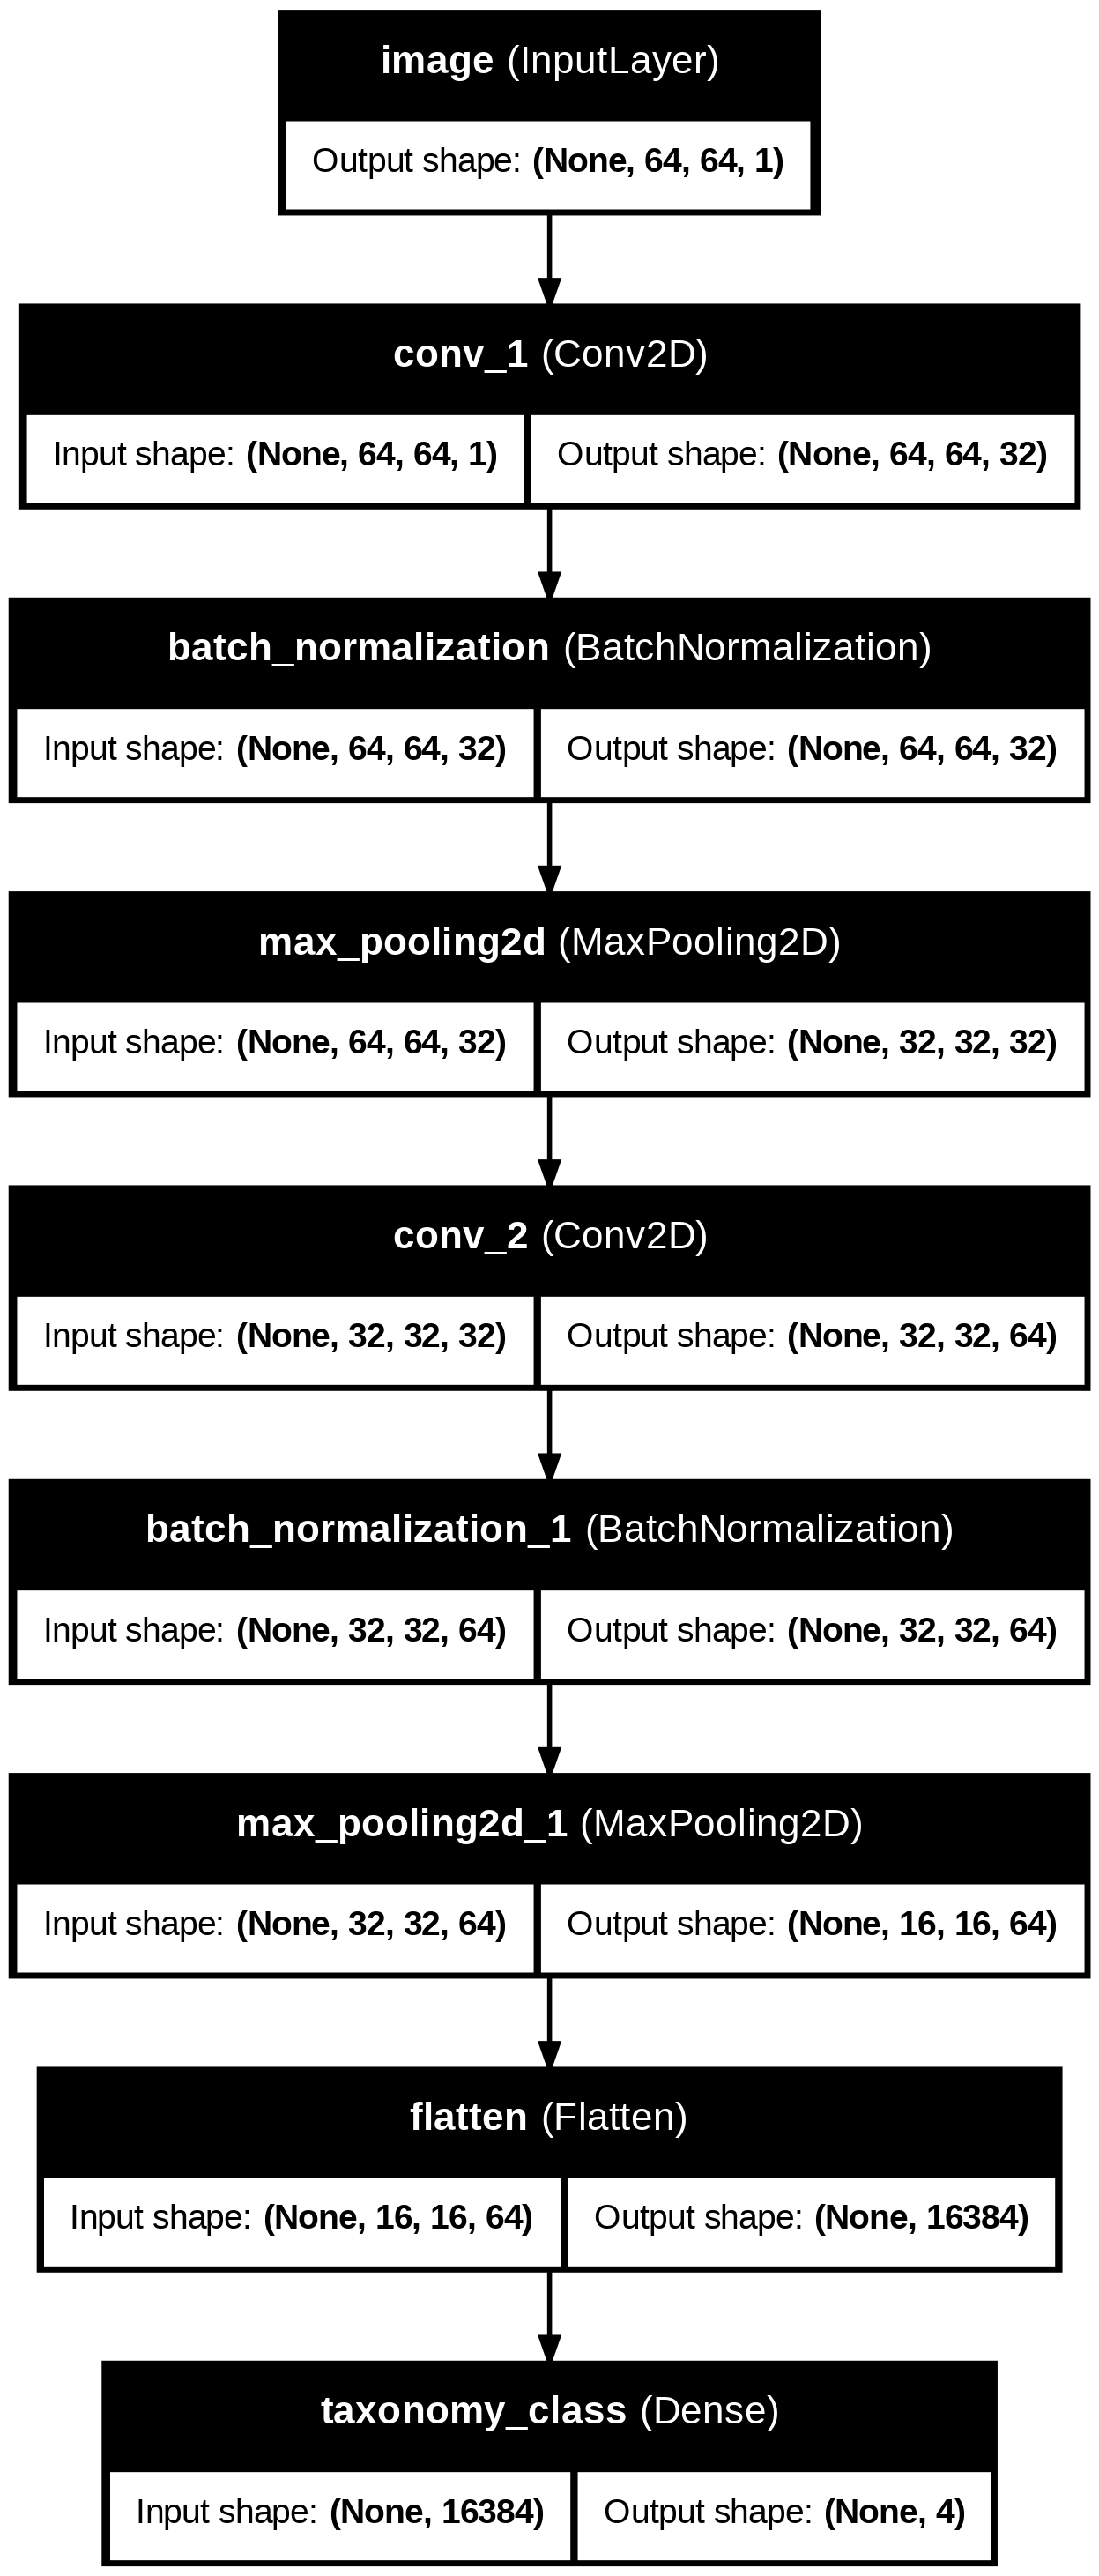

In [58]:
plot_model(evaluation_model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [60]:
def build_evaluation_model_2(img_size, output_size):
  """ Train model based on selected parameters and display results
  Using Model_2 which has 2 blocks of convolutional layer followed by MaxPool
  Adding dropout
  """
  kernel = 2
  l_r = 0.01
  optimizer = 'Adam'
  strides=(2,2)


  tf.keras.backend.clear_session()
  tf.random.set_seed(1234)
  np.random.seed(1234)


  # build model
  image = tf.keras.layers.Input(shape=(img_size, img_size, 1), dtype=tf.float32, name='image')
  # Block 1
  conv_1 = tf.keras.layers.Conv2D(filters=32,
      kernel_size=(kernel,kernel),
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_1',
      activation='relu')(image)
  normal_1 = tf.keras.layers.BatchNormalization()(conv_1)
  maxpool_1 = tf.keras.layers.MaxPooling2D((2,2))(normal_1)

  # Block 2
  conv_2 = tf.keras.layers.Conv2D(filters= 64,
      kernel_size=(kernel,kernel),
      strides=strides,
      padding='same',
      data_format="channels_last",
      name='conv_2',
      activation='relu')(maxpool_1)
  normal_2 = tf.keras.layers.BatchNormalization()(conv_2)
  maxpool_2 = tf.keras.layers.MaxPooling2D((2,2))(normal_2)

  flat_1 = tf.keras.layers.Flatten()(maxpool_2)
  dropout_1 = tf.keras.layers.Dropout(0.3)(flat_1)

  # Add classification layer
  taxonomy_class = tf.keras.layers.Dense(
      units=output_size, activation='softmax', name='taxonomy_class')(dropout_1)

  model = tf.keras.Model(inputs=image,
                         outputs=taxonomy_class,
                         name='BirdClef')

  # compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
      loss=tf.keras.losses.CategoricalCrossentropy(),
       metrics=['accuracy',
               tf.keras.metrics.F1Score(average="macro")])


  # print model_tf summary
  print(model.summary())
  return model



Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,900 (50.39 KB)

 Trainable params: 12,708 (49.64 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.3685 - f1_score: 0.2898 - loss: 2.6931 - val_accuracy: 0.0205 - val_f1_score: 0.0100 - val_loss: 1.2620 - learning_rate: 0.0100
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4719 - f1_score: 0.3765 - loss: 1.5267 - val_accuracy: 0.0665 - val_f1_score: 0.0331 - val_loss: 1.2485 - learning_rate: 0.0100
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4825 - f1_score: 0.4009 - loss: 1.3739 - val_accuracy: 0.1213 - val_f1_score: 0.0580 - val_loss: 1.0388 - learning_rate: 0.0100
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5146 - f1_score: 0.4225 - loss: 1.1886 - val_accuracy: 0.1696 - val_f1_score: 0.0778 - val_loss: 1.2001 - learning_rate: 0.0100
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5554 - f1_score: 0.4483 - loss: 1.0591 - val_accuracy: 0.1934 - val_f1_score: 0.0872 - val_loss: 1.1532 - learning_rate: 0.0100
Epoch 6/20
57/57 ━━━━━━━━━━━━━

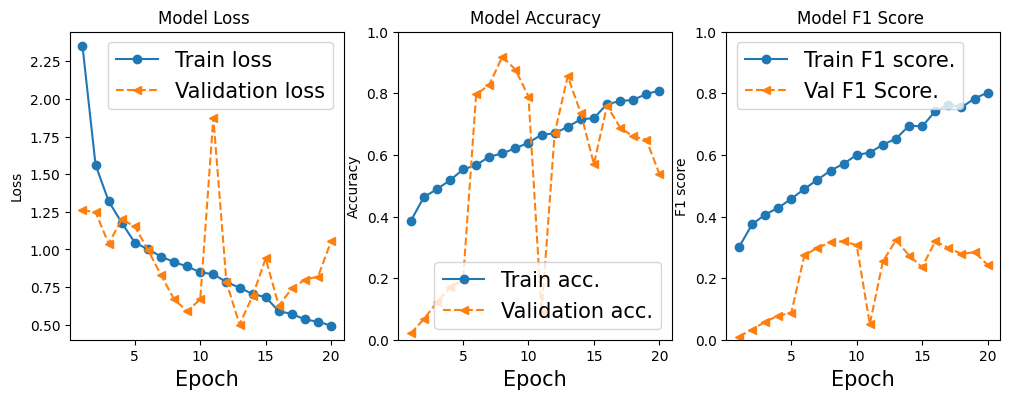

final train acc: 0.809
final val acc:   0.539

Unable to calculate percent diff as Train accuracy is zero
test_label length :  1818
predicted_labels length :  1818
confusion matrix shape= (4, 4)


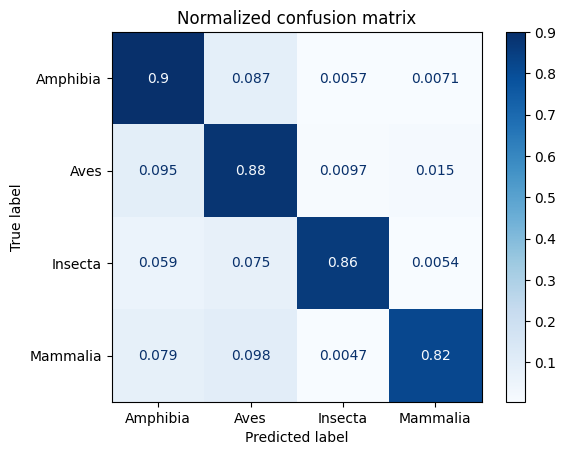

              precision    recall  f1-score   support

    Amphibia       0.87      0.90      0.88       700
        Aves       0.87      0.88      0.87       718
     Insecta       0.93      0.86      0.89       186
    Mammalia       0.91      0.82      0.86       214

    accuracy                           0.88      1818
   macro avg       0.89      0.86      0.88      1818
weighted avg       0.88      0.88      0.88      1818



In [61]:
#rerun with evaluation model 2

evaluation_model = build_evaluation_model_2(X_under_2_specaugm.shape[1],y_under_2_specaugm .shape[1])

# train model on (X_train, y_train) data
history = evaluation_model.fit(
    X_under_2_specaugm,
    y_under_2_specaugm,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    batch_size=32,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(evaluation_model, X_under_2_specaugm, y_under_2_specaugm)

In [62]:
result_eval = evaluation_model.evaluate(X_common_test,
                          y_class_test,
                                        return_dict=True)


print("evaluation results = ", result_eval)
print('\nTest Acc. {:.4f}%'.format(result_eval.get('accuracy')*100))
print('\nTest F1-score MACRO. {:.4f}%'.format(result_eval.get('f1_score')*100))



179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5385 - f1_score: 0.2403 - loss: 1.0587
evaluation results =  {'accuracy': 0.5335200428962708, 'f1_score': 0.23876658082008362, 'loss': 1.074977159500122}

Test Acc. 53.3520%

Test F1-score MACRO. 23.8767%


We observe that the final model shows no significant improvement over the previous runs. Future steps, time permitting might include using higher resolution image data and a more advanced model architecture and data augmentation.

### Spectrogram Augmentation

In [63]:
X_class_augm, y_class_augm  = add_spectrogram_augmentation(X_common_train,y_class_train )

Reshaped spectrogram shape :  (17138, 64, 64)
Augmented spectrograms shape:  (17138, 64, 64)
Reshaped Augmented spectrograms shape:  (17138, 64, 64, 1)
After augmentation: X shape: (34276, 64, 64, 1)
After augmentation: y shape: (34276, 4)


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,900 (50.39 KB)

 Trainable params: 12,708 (49.64 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9521 - f1_score: 0.2493 - loss: 0.3517 - val_accuracy: 0.9680 - val_f1_score: 0.2459 - val_loss: 0.2019 - learning_rate: 0.0100
Epoch 2/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9695 - f1_score: 0.2461 - loss: 0.1702 - val_accuracy: 0.9680 - val_f1_score: 0.2459 - val_loss: 0.2010 - learning_rate: 0.0100
Epoch 3/20
1062/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - f1_score: 0.2461 - loss: 0.1688
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9694 - f1_score: 0.2461 - loss: 0.1688 - val_accuracy: 0.9680 - val_f1_score: 0.2459 - val_loss: 0.2131 - learning_rate: 0.0100
Epoch 4/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9693 - f1_score: 0.2497 - loss: 0.1625 - val_accuracy: 0.9680 - val_f1_score: 0.2459 - val_loss: 0.1644 - learning_rate: 0.0050
Epoch 5/20
1060/1072 ━━━━━━━━━━━━━━━━━━

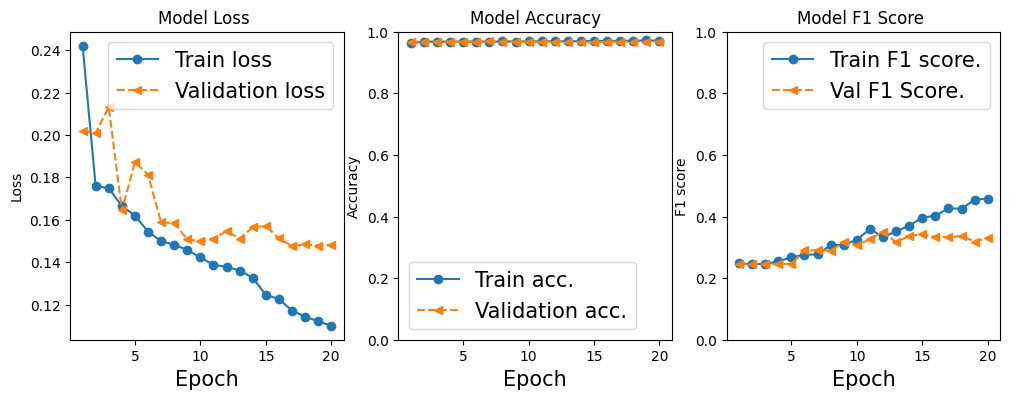

final train acc: 0.971
final val acc:   0.968

Unable to calculate percent diff as Train accuracy is zero
test_label length :  34276
predicted_labels length :  34276
confusion matrix shape= (4, 4)


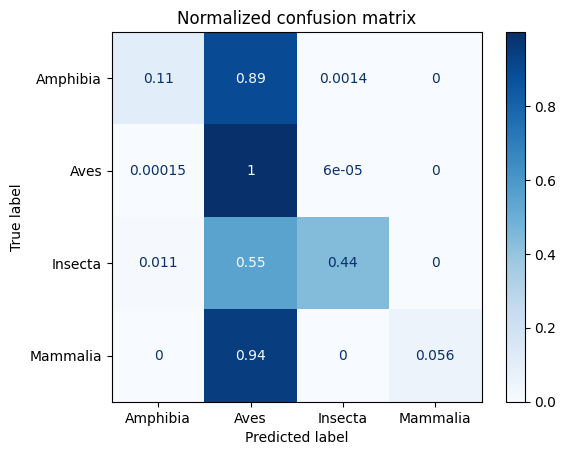

              precision    recall  f1-score   support

    Amphibia       0.91      0.11      0.19       700
        Aves       0.97      1.00      0.99     33176
     Insecta       0.96      0.44      0.61       186
    Mammalia       1.00      0.06      0.11       214

    accuracy                           0.97     34276
   macro avg       0.96      0.40      0.47     34276
weighted avg       0.97      0.97      0.96     34276



In [64]:
evaluation_model = build_evaluation_model_2(X_class_augm.shape[1],y_class_augm.shape[1])

# train model on (X_train, y_train) data
history = evaluation_model.fit(
    X_class_augm,
    y_class_augm,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    batch_size=32,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(evaluation_model, X_class_augm, y_class_augm)

In [65]:
result_eval = evaluation_model.evaluate(X_common_test,
                          y_class_test,
                                        return_dict=True)


print("evaluation results = ", result_eval)
print('\nTest Acc. {:.4f}%'.format(result_eval.get('accuracy')*100))
print('\nTest F1-score MACRO. {:.4f}%'.format(result_eval.get('f1_score')*100))

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9692 - f1_score: 0.2760 - loss: 0.1502
evaluation results =  {'accuracy': 0.9679678082466125, 'f1_score': 0.2924027740955353, 'loss': 0.14918522536754608}

Test Acc. 96.7968%

Test F1-score MACRO. 29.2403%


Model: "BirdClef"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ taxonomy_class (Dense)          │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,300 (387.89 KB)

 Trainable params: 99,108 (387.14 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9204 - f1_score: 0.2506 - loss: 4.1346 - val_accuracy: 0.0203 - val_f1_score: 0.0100 - val_loss: 8.9668 - learning_rate: 0.0100
Epoch 2/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9243 - f1_score: 0.2515 - loss: 0.5708 - val_accuracy: 0.0205 - val_f1_score: 0.0251 - val_loss: 21.1293 - learning_rate: 0.0100
Epoch 3/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9253 - f1_score: 0.2655 - loss: 0.6604 - val_accuracy: 0.1413 - val_f1_score: 0.0881 - val_loss: 3.8044 - learning_rate: 0.0100
Epoch 4/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9347 - f1_score: 0.2705 - loss: 0.4275 - val_accuracy: 0.9491 - val_f1_score: 0.3520 - val_loss: 0.2580 - learning_rate: 0.0100
Epoch 5/20
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9378 - f1_score: 0.2878 - loss: 0.4029 - val_accuracy: 0.9559 - val_f1_score: 0.3303 - val_loss: 0.1952 - learning_rate: 0.0100
Epoch 6/20
1

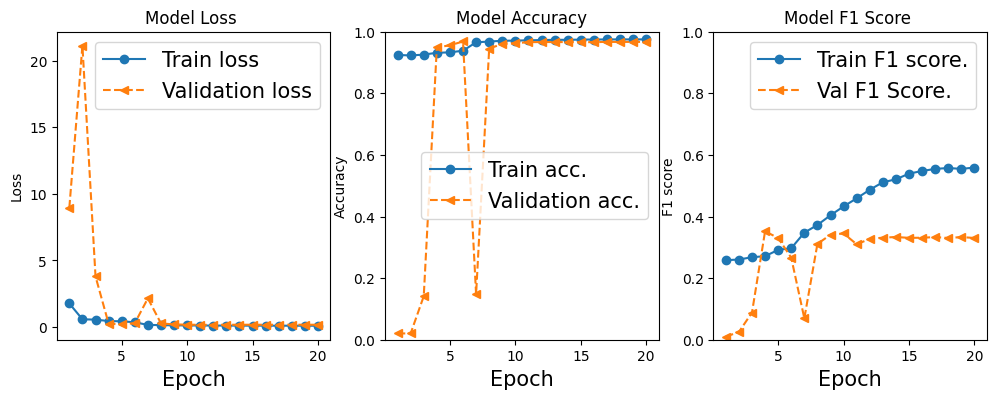

final train acc: 0.975
final val acc:   0.967

Unable to calculate percent diff as Train accuracy is zero
test_label length :  34276
predicted_labels length :  34276
confusion matrix shape= (4, 4)


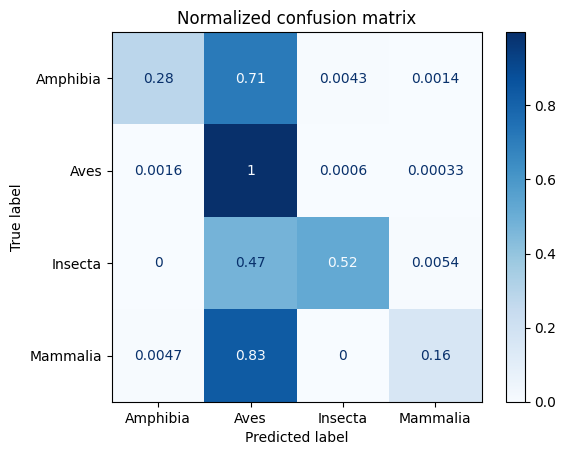

              precision    recall  f1-score   support

    Amphibia       0.79      0.28      0.42       700
        Aves       0.98      1.00      0.99     33176
     Insecta       0.81      0.52      0.63       186
    Mammalia       0.73      0.16      0.27       214

    accuracy                           0.98     34276
   macro avg       0.83      0.49      0.58     34276
weighted avg       0.97      0.98      0.97     34276



In [66]:
evaluation_model = build_evaluation_model(X_class_augm.shape[1],y_class_augm.shape[1])

# train model on (X_train, y_train) data
history = evaluation_model.fit(
    X_class_augm,
    y_class_augm,
    validation_data=(X_common_val,y_class_val),
    callbacks=[ reduce_lr_f1],
    batch_size=32,
    epochs=20)

# plot loss curves
show_history(history)

#plot confusion matrix
plot_confusion_matrix(evaluation_model, X_class_augm, y_class_augm)

In [67]:
result_eval = evaluation_model.evaluate(X_common_test,
                          y_class_test,
                                        return_dict=True)


print("evaluation results = ", result_eval)
print('\nTest Acc. {:.4f}%'.format(result_eval.get('accuracy')*100))
print('\nTest F1-score MACRO. {:.4f}%'.format(result_eval.get('f1_score')*100))

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9662 - f1_score: 0.3076 - loss: 0.1616
evaluation results =  {'accuracy': 0.964992105960846, 'f1_score': 0.3279487192630768, 'loss': 0.16779616475105286}

Test Acc. 96.4992%

Test F1-score MACRO. 32.7949%
